In [1]:
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
import re
import seaborn as sns
import time
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
with open('df_amenities_neighbourhood_all.pkl') as f:
    df = pickle.load(f)

In [3]:
df.head(2)

,id,name,summary,latitude,longitude,space,description,neighborhood_overview,notes,transit,...,atm,cinema,hospital,nightclub,park,mall,gallery,museum,supermarket,bus_stop
0,8238835,Cozy BR + EnSuite @ York University,We are located at York University. Close to Yo...,43.768740,-79.502254,The house is located less than 100 meters from...,We are located at York University. Close to Yo...,"Our house is ideal for students, professionals...","Please note, this room does not have a window....",The bus stop is right in front of our home on ...,...,509,5812,5400,1060,3269,7227,-1,9607,1709,72
1,16162206,"Large sunny bedroom, 3d floor (3A)",This room is one of 4 bedrooms available in a ...,43.765573,-79.492943,NaN,This room is one of 4 bedrooms available in a ...,NaN,NaN,NaN,...,1212,5480,4588,1151,2694,6488,-1,9476,1213,77


### Price - the variable to be predicted

We start by examining the price column - statistical moments, ranges, basic plots

In [4]:
get_numeric_price = lambda x:int(re.sub(',', '', x.split('.')[0][1:])) # Function to convert price string to numeric: $45.00 -> 45 
df['price'] = df['price'].apply(get_numeric_price)

In [5]:
highest_indices = df.price.sort_values(ascending=False)[:5].index
for i in highest_indices:
    print 'Listed Price:', df.ix[i,'price'], 'URL: https://www.airbnb.com/rooms/'+ str(df.ix[i,'id'])

# Except for the 1st one (which was probably scraped wrongly or wrongly posted initially by the host), 
# the remaining are actually that expensive!  
# There could be minor difference between the current price and the price when the data was scraped

Listed Price: 5500 URL: https://www.airbnb.com/rooms/11219978
Listed Price: 4000 URL: https://www.airbnb.com/rooms/13788645
Listed Price: 2999 URL: https://www.airbnb.com/rooms/5371576
Listed Price: 2780 URL: https://www.airbnb.com/rooms/9526699
Listed Price: 2500 URL: https://www.airbnb.com/rooms/16062958


In [6]:
lowest_indices = df.price.sort_values(ascending=True)[:5].index
for i in lowest_indices:
    print 'Listed Price:', df.ix[i,'price'], 'URL: https://www.airbnb.com/rooms/'+ str(df.ix[i,'id'])

# There could be minor difference between the current price and the price when the data was scraped
# There are indeed cheap airbnbs

Listed Price: 13 URL: https://www.airbnb.com/rooms/10023011
Listed Price: 15 URL: https://www.airbnb.com/rooms/6846217
Listed Price: 15 URL: https://www.airbnb.com/rooms/15481128
Listed Price: 15 URL: https://www.airbnb.com/rooms/10361301
Listed Price: 15 URL: https://www.airbnb.com/rooms/13913400


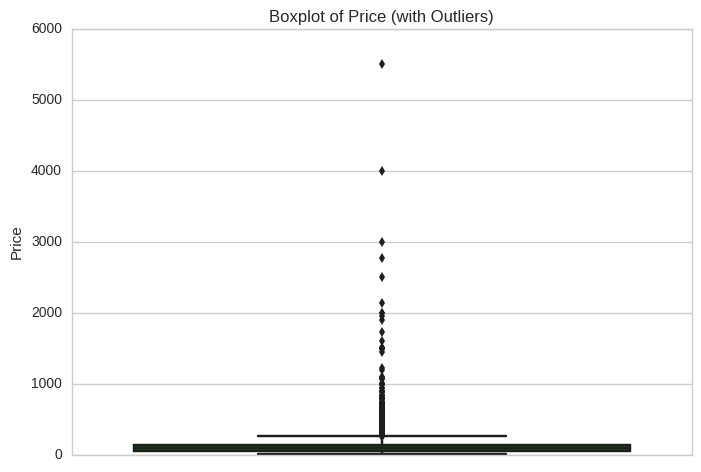

In [7]:
ax = sns.boxplot(y = df['price'], color='darkgreen')
ax.set(ylabel='Price', title = 'Boxplot of Price (with Outliers)')

As seen in the the box above, there seems to be a number with extremely high prices. These are discarded from the model. <br> For outlier removal, the Inter-Quartile Metric is used as described below:
<code>
IQR = 3rd quartile - 1st quartile
Any value greater than (3rd quartile + 1.5\*IQR) is considered an outlier
Any value less than (1st quartile - 1.5\*IQR) is considered an outlier

Reference: http://www.mathwords.com/o/outlier.htm
</code>

In [8]:
iqr = df['price'].quantile(q=0.75)-df['price'].quantile(0.25)
lower_limit = max(0, df['price'].quantile(0.25)-1.5*iqr) # The price cannot be negative. So a constaint is kept
upper_limit = df['price'].quantile(0.75)+1.5*iqr

print "Only prices between", lower_limit, "and", upper_limit,"are retained in the dataset."

remove_index = df[df['price'] > upper_limit].index
df.drop(remove_index, inplace=True)
df.reset_index(inplace=True, drop=True)
print "The number of rows removed = ", len(remove_index)

Only prices between 0 and 269.5 are retained in the dataset.
The number of rows removed =  563


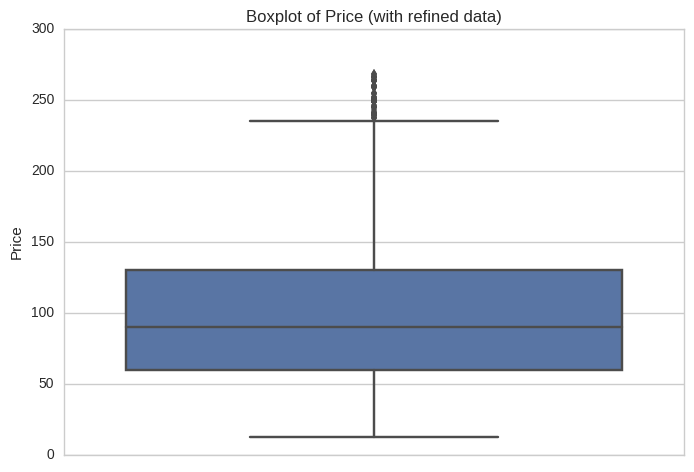

In [9]:
ax = sns.boxplot(y = df['price'])
ax.set(ylabel='Price', title = 'Boxplot of Price (with refined data)')

In [10]:
# Some descriptive statistics of the price column after removing outliers
print df.price.describe()

count    9232.000000
mean      101.510399
std        52.898753
min        13.000000
25%        60.000000
50%        90.000000
75%       130.000000
max       268.000000
Name: price, dtype: float64


<code>
From the histogram, we can see that price is approximately normally distributed but with a positive skewness
</code>

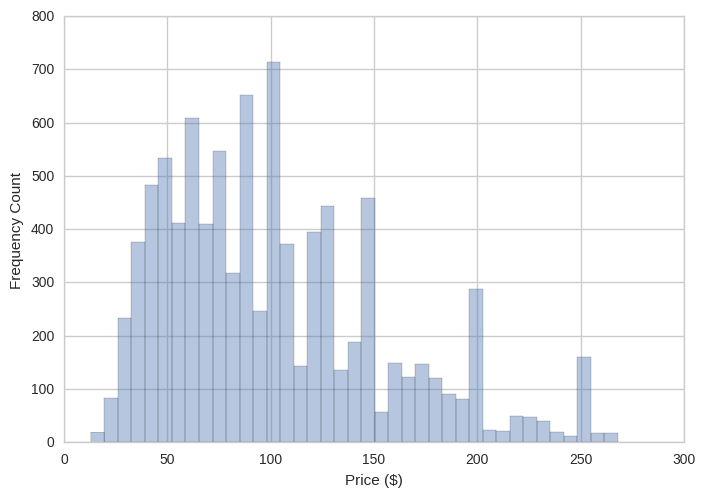

In [11]:
sns.distplot(df['price'], kde=False, axlabel='Price ($)')
plt.ylabel('Frequency Count')

Skewness =  0.873696815331


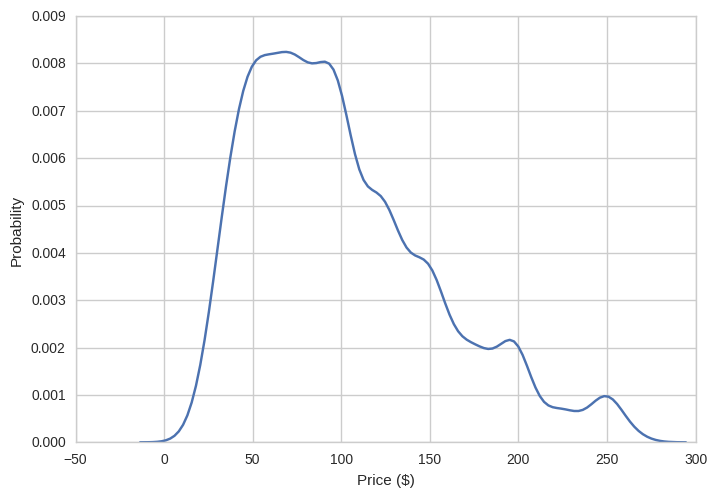

In [12]:
sns.distplot(df['price'], hist=False, axlabel='Price ($)') # Density PLot
plt.ylabel('Probability')
print "Skewness = ", df['price'].skew()

In [13]:
# A variable called host experience that represents
# the difference in terms of the number of months since the host joined airbnb and
# the day the scraping was carried out

df.dropna(subset=['host_since'], inplace=True) # Drop 1 row which had that attribute as NA
df.reset_index(inplace=True, drop=True)

calculate_host_experience = lambda x: int(time.mktime(time.strptime('2017-02-01', "%Y-%m-%d"))/(24*60*60*30)) - int(time.mktime(time.strptime(x, "%Y-%m-%d"))/(24*60*60*30))
df['host_exp'] = df['host_since'].apply(calculate_host_experience)

Mean: 30.6725519931
Median: 27.0
Max: 103


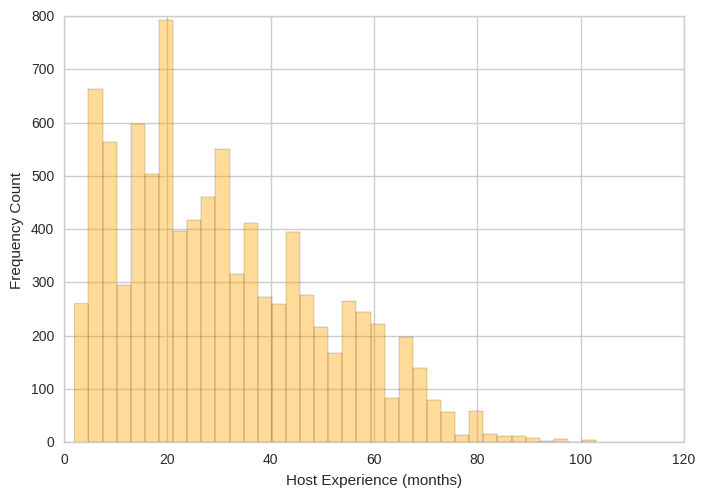

In [14]:
print "Mean:", df['host_exp'].mean()
print "Median:", df['host_exp'].median()
print "Max:", df['host_exp'].max()
sns.distplot(df['host_exp'], kde=False, axlabel='Host Experience (months)', color='orange')
plt.ylabel('Frequency Count')

<code>
Most hosts have an experience of 2 to 2.5 years (24-30 months). However, the maximum experience is 8.5 years (103 months)
</code>

In [15]:
# Most hosts respond within a hour, only a very small percent of the hosts take over a day to reply
df['host_response_time'].value_counts(dropna=False)

within an hour        4094
within a few hours    2047
NaN                   1753
within a day          1163
a few days or more     175
Name: host_response_time, dtype: int64

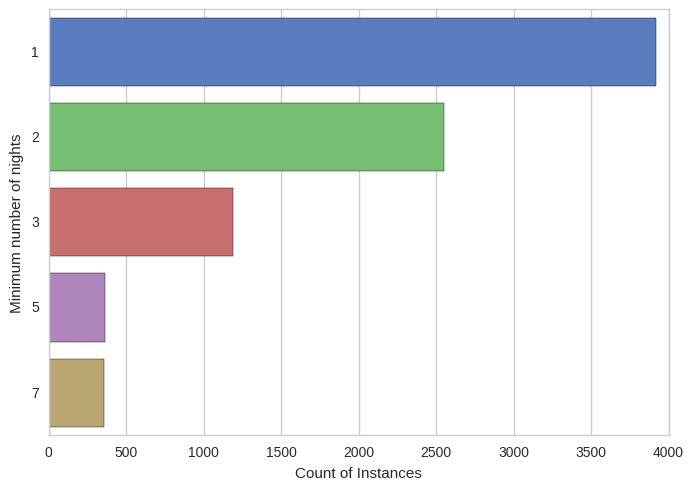

In [16]:
min_nights = df['minimum_nights'].value_counts(dropna=False)[:5]
sns.barplot(x=min_nights, y=min_nights.index, palette="muted",orient = 'h')
plt.xlabel('Count of Instances')
plt.ylabel('Minimum number of nights')

<code>
Most people rent their house with a minimum 1-night stay condition. Min 2 or 3 night listings are also common. 
Beyond that the frequency is very less (because these are vacation rentals)
</code>

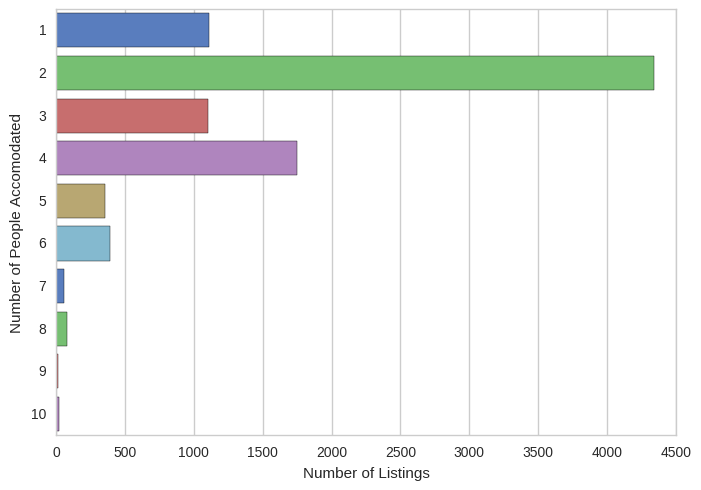

In [17]:
accommodates = df['accommodates'].value_counts(dropna=False)[:10]
sns.barplot(x=accommodates.values, y=accommodates.index, palette="muted",orient = 'h')
plt.xlabel('Number of Listings')
plt.ylabel('Number of People Accomodated')

<code>Most listings are intented to accomodate 2 people. 

In [18]:
df.guests_included.value_counts()[:4]

1    6064
2    1980
0     403
4     398
Name: guests_included, dtype: int64

<code>
Most listings (>50%) indicate that the price mentioned is accomodation for 1 person.
However, there are some mentions of 0 guests included. This cannot obviously be correct. It could be that the advertisement posters had an ambiguity of number of extra guests that can be included, rather than the actual number of guests that the price covers for.  
</code>

In [19]:
df.extra_people.value_counts(dropna=False) [:5]

$0.00     5010
$20.00     834
$10.00     822
$25.00     573
$15.00     554
Name: extra_people, dtype: int64

<code>Most records (>50%) have a value $0 which means "no extra charge for extra guests".
</code>

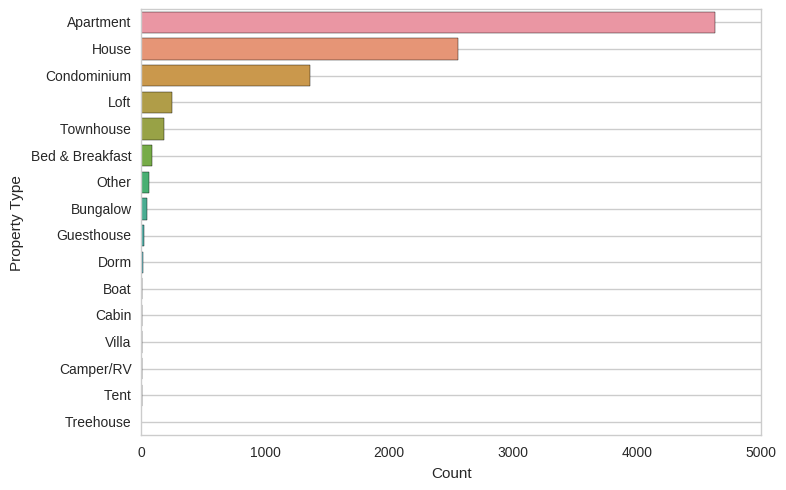

In [20]:
property_type = df['property_type'].value_counts()
sns.barplot(y=property_type.index, x=property_type.values, orient='h')
plt.xlabel('Count')
plt.ylabel('Property Type')
plt.grid()

<code>Most of the listings are either a house or Apartment. However, there are very few treehouses, tents, boats, etc.

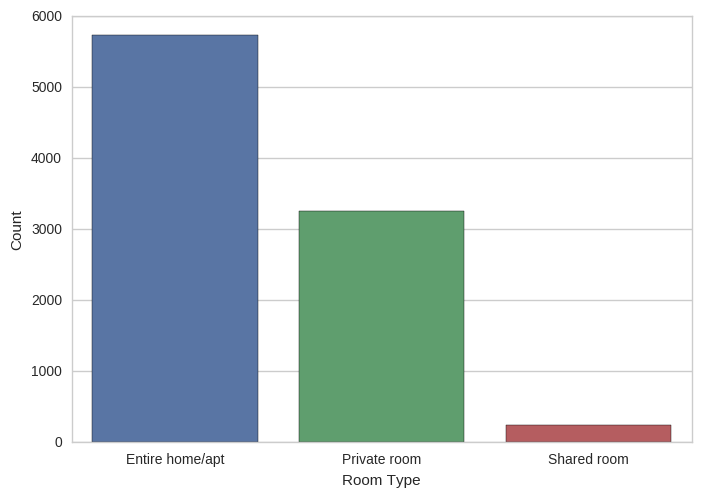

In [21]:
room_type = df['room_type'].value_counts()
sns.barplot(room_type.index, room_type.values)
plt.xlabel('Room Type')
plt.ylabel('Count')

<code>Over 5000 listings provide the entire home for rent. About 3000 listings refer to a private room in a house. Whereas only a small percentage of the houses provide a shared room.

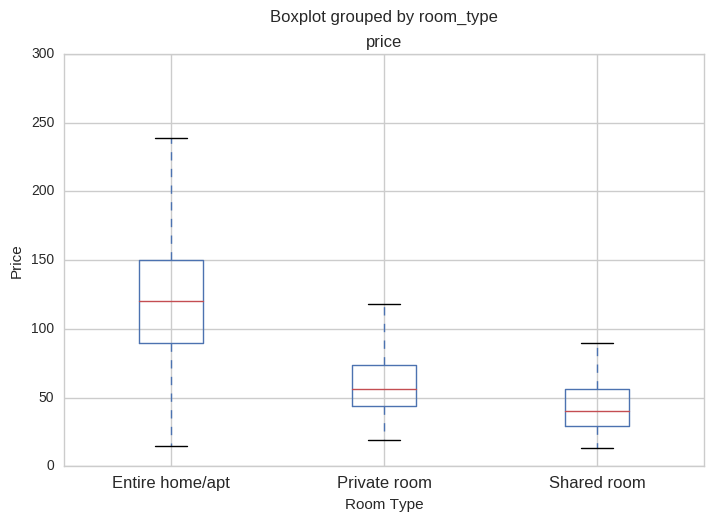

In [22]:
df.boxplot(column='price', by='room_type')
plt.xlabel('Room Type')
plt.ylabel('Price')

<code>There is a distinction of the price variable by room type. Shared rooms, as expected, do have a lower price than the listings where the entire house/apartment is provided for rent. 

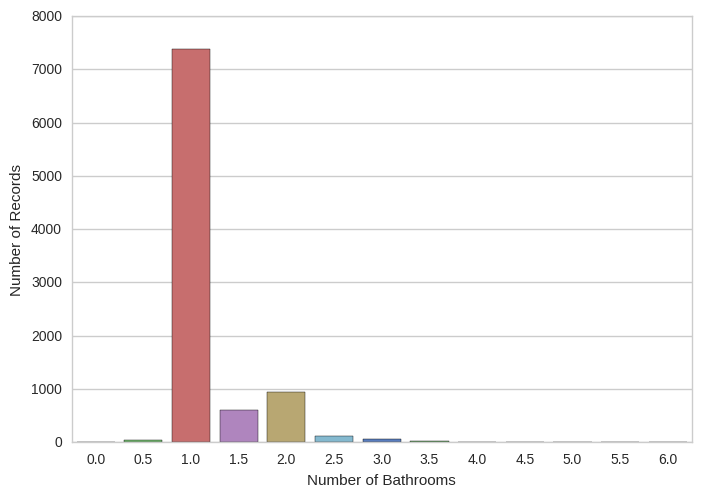

In [23]:
bathrooms = df['bathrooms'].value_counts()
sns.barplot(x=bathrooms.index, y=bathrooms.values, palette="muted")
plt.ylabel('Number of Records')
plt.xlabel('Number of Bathrooms')

<code>Over 80% of the houses provide a single bathroom. Some listings have zero bathrooms! We realize that these are the ones where the listing refers to a property type of 'tent'

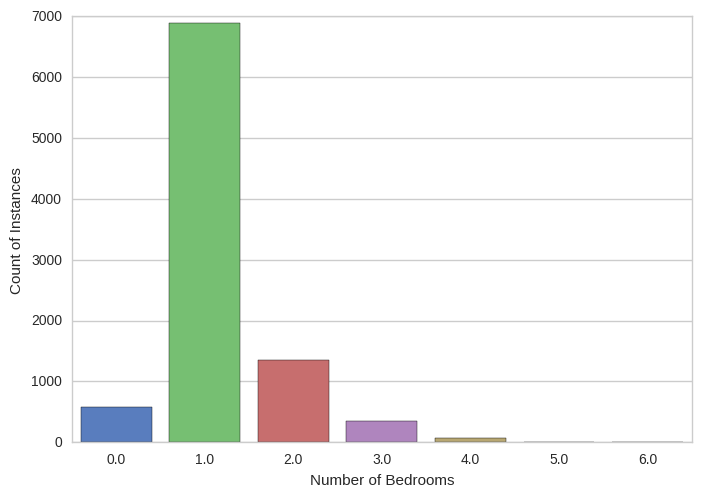

In [24]:
bedrooms = df['bedrooms'].value_counts()
sns.barplot(x=bedrooms.index, y=bedrooms.values, palette="muted")
plt.ylabel('Count of Instances')
plt.xlabel('Number of Bedrooms')

<code>Zero bedroom could either refer to a listing type like tent. Or Could correspond to listings that allows to rent the living room/couch.

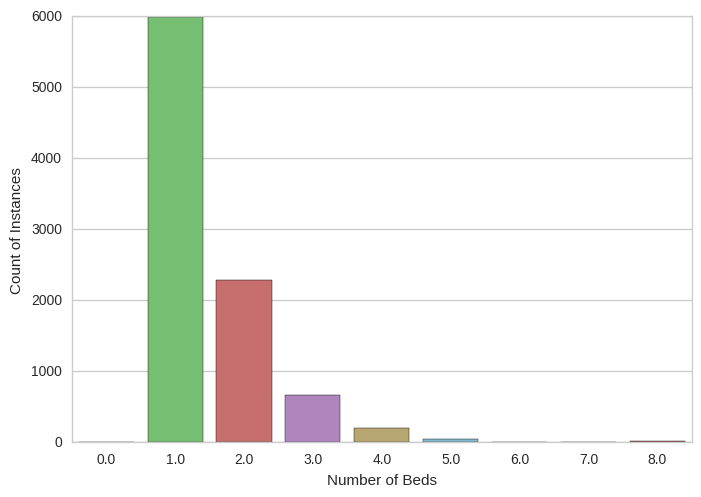

In [25]:
beds = df['beds'].value_counts()
sns.barplot(x=beds.index, y=beds.values, palette="muted")
plt.ylabel('Count of Instances')
plt.xlabel('Number of Beds')

<code>Here again, zero could refer to listings that only have couches and no bed. However, most listings offer a single bed.

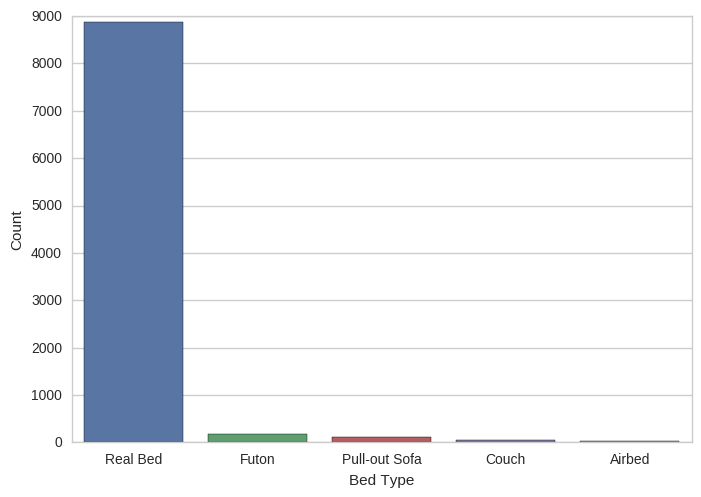

In [26]:
bed_type = df['bed_type'].value_counts()
sns.barplot(bed_type.index, bed_type.values)
plt.xlabel('Bed Type')
plt.ylabel('Count')

<code>Most listings provide a real bed rather than a sofa or couch to the travelers

Max Reviews: 401


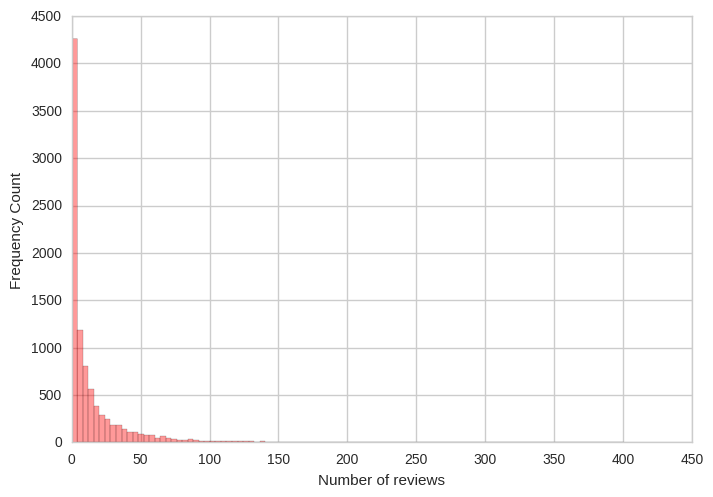

In [27]:
sns.distplot(df['number_of_reviews'], kde=False, axlabel='Number of reviews', color='red', bins=100)
plt.ylabel('Frequency Count')
print "Max Reviews:", df['number_of_reviews'].max()

<code>
Most hosts/listings do not have even 1 traveller review. The maximum number of reviews that a listing has received is 401
</code>

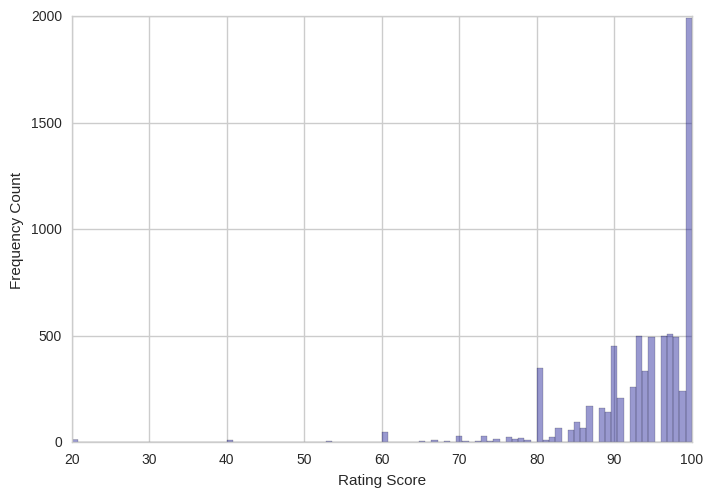

In [28]:
sns.distplot(df['review_scores_rating'].dropna(), kde=False, axlabel='Rating Score', color='darkblue', bins=100)
plt.ylabel('Frequency Count')

<code>
Among the listings that have been rated, most of them have been rated very high (scores greater than 90). There were 1993 listings that had a perfect rating of 100.
</code>

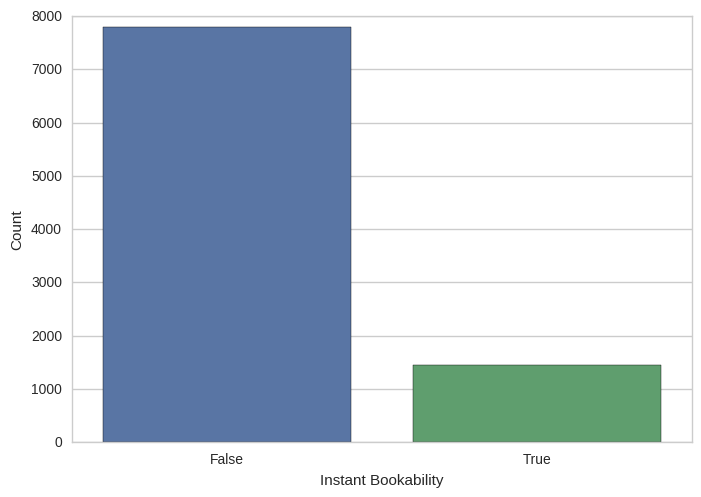

In [29]:
instant_booking = df.instant_bookable.value_counts()
instant_booking_dict = {'f':'False', 't':'True'}
sns.barplot([instant_booking_dict[i] for i in instant_booking.index], instant_booking.values)
plt.xlabel('Instant Bookability')
plt.ylabel('Count')

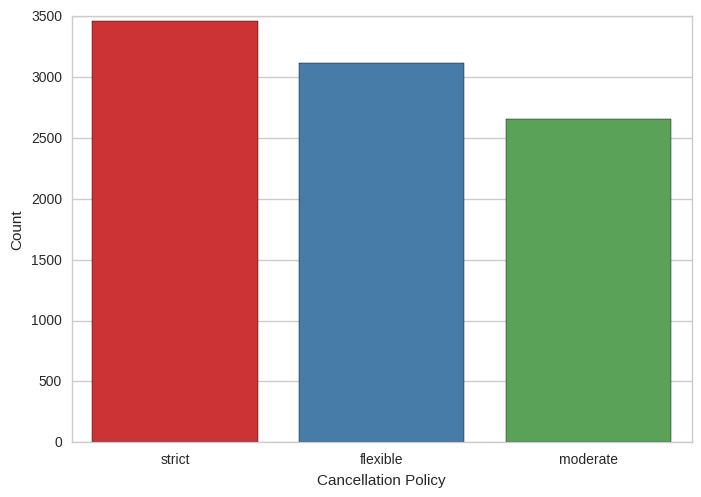

In [30]:
sns.barplot(pd.Series(df['cancellation_policy'].value_counts()).index, pd.Series(df['cancellation_policy'].value_counts()).values, palette='Set1')
plt.xlabel('Cancellation Policy')
plt.ylabel('Count')

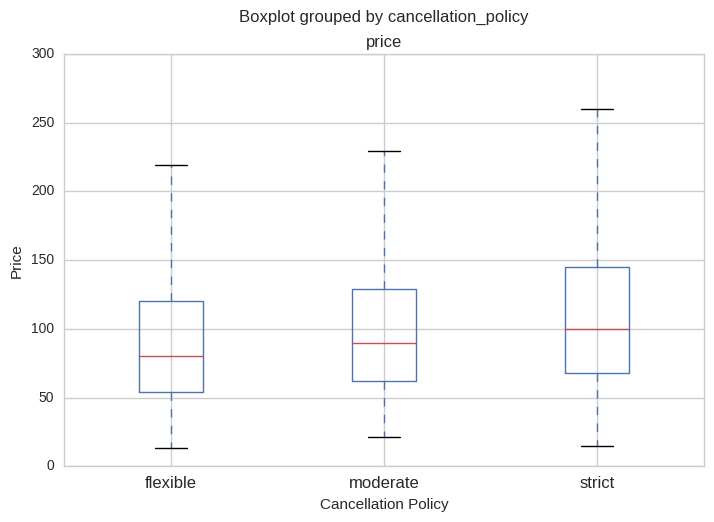

In [31]:
df.boxplot(column='price', by='cancellation_policy')
plt.xlabel('Cancellation Policy')
plt.ylabel('Price')

<code>Strict cancellation policy house owners tend to price houses marginally higher.

Frequency Counts
1    5604
2    1335
Name: calculated_host_listings_count, dtype: int64
Max: 62


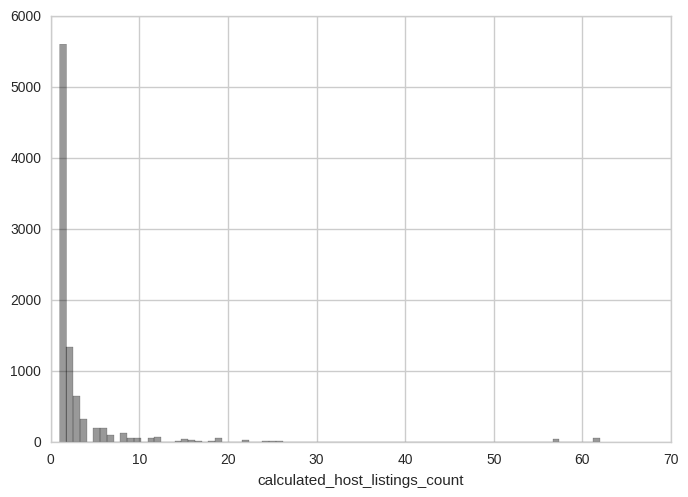

In [32]:
sns.distplot(df['calculated_host_listings_count'], kde=False, bins=80, color='black')
print "Frequency Counts\n", df['calculated_host_listings_count'].value_counts()[:2]
print "Max:", df['calculated_host_listings_count'].max()

<code>
5604 hosts out of the total have just 1 property listed, 1335 have two. 
The maximum number of properties listed by a single host is 62. It is possible that this user name is owned by a real-estate agency with a large number of houses/appartments to rent.
<code>

Frequency Counts
1    300
2    249
4    244
3    226
6    201
Name: num_page_saved, dtype: int64
Max: 3151


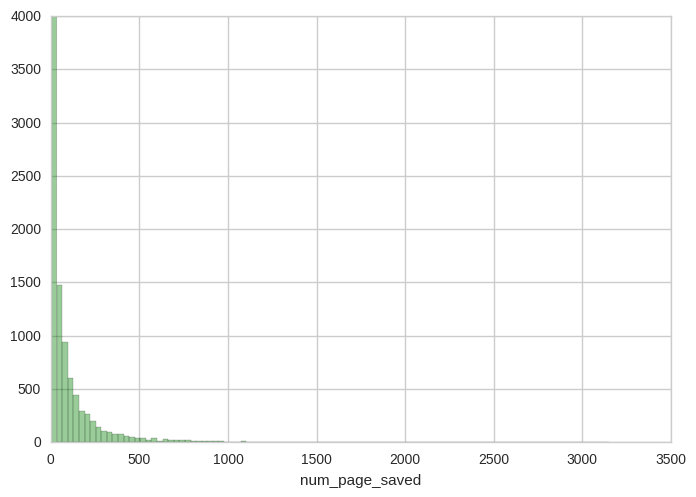

In [33]:
# Number of time this 'listing was saved' histogram
sns.distplot(df['num_page_saved'], kde=False, bins=100, color='green')
print "Frequency Counts\n", df['num_page_saved'].value_counts()[:5]
print "Max:", df['num_page_saved'].max()

<code>Exponential decay - most listings are just saved by a handful of people. The max. people who has saved a listing is 3151</code>

### Amenities

In [34]:
# Combine some amenities like parkings
print df['Free parking on street'].value_counts() # Only 3 records that have a value = 1 for this column
print df['Paid parking off premises'].value_counts() # Only 14 records that have a value = 1 for this column

0    9229
1       3
Name: Free parking on street, dtype: int64
0    9218
1      14
Name: Paid parking off premises, dtype: int64


In [35]:
# Merge all columns that describe 'parking information' into a single column 
df['Parking'] = [df.ix[i, 'Free parking on street'] or df.ix[i, 'Free parking on premises'] or df.ix[i, 'Paid parking off premises'] for i in range(df.shape[0])]
df.drop(['Free parking on street', 'Free parking on premises', 'Paid parking off premises'], axis=1, inplace=True)
df['Parking'].value_counts()

0    5373
1    3859
Name: Parking, dtype: int64

In [36]:
df.to_pickle('df_amenities_neighbourhood_all_processed.pkl')

#### Amenitites Plots

<code> Amenitites are binary explanatory variables. 
-Barplots to check counts of Os and 1s
</code>

In [30]:
amenities = [u'Elevator in building', u'Internet', u'Family/kid friendly', u'Wireless Internet',
             u'Buzzer/wireless intercom', u'Kitchen', u'Doorman', u'Wheelchair accessible', u'Cable TV',
             u'Hot tub', u'Gym', u'Pool', u'TV', u'Dryer', u'Washer', u'Essentials', u'Shampoo', u'Heating',
             u'Air conditioning', u'Pets allowed', u'Suitable for events', u'Smoking allowed', 
             u'Indoor fireplace', u'Breakfast', u'Laptop friendly workspace', u'Iron', u'Hangers', u'Hair dryer', 
             u'Private living room', u'Private entrance', u'Parking']

0    5051
1    4181
Name: Elevator in building, dtype: int64


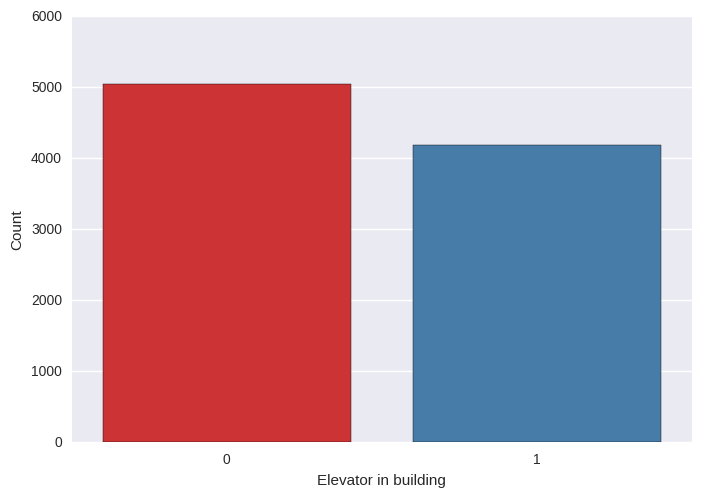

1    6418
0    2814
Name: Internet, dtype: int64


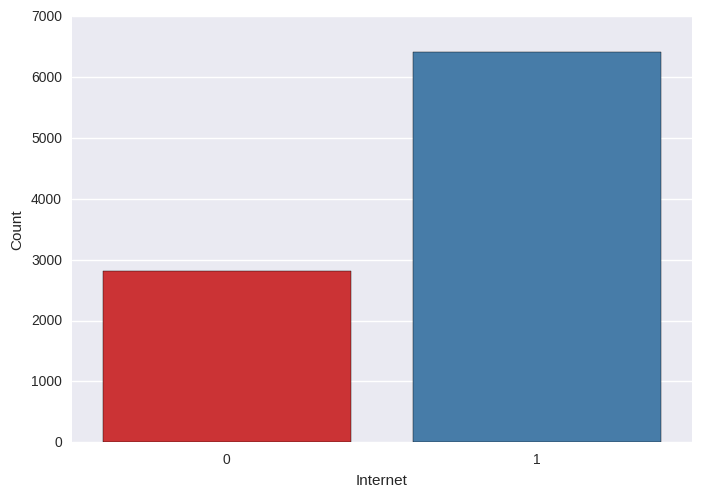

1    5131
0    4101
Name: Family/kid friendly, dtype: int64


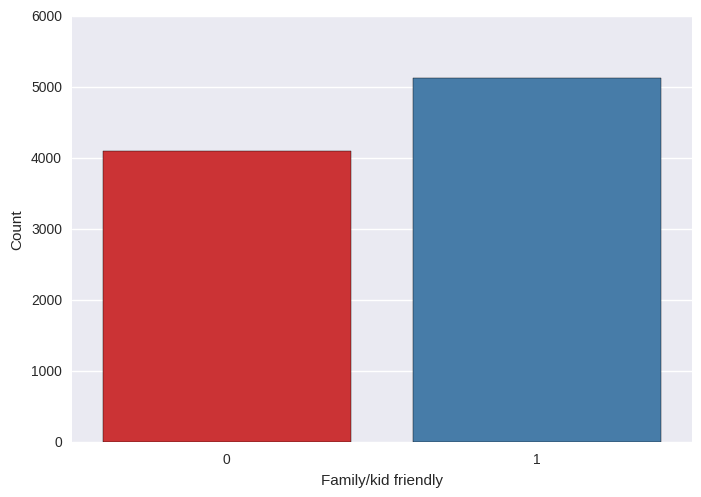

1    8942
0     290
Name: Wireless Internet, dtype: int64


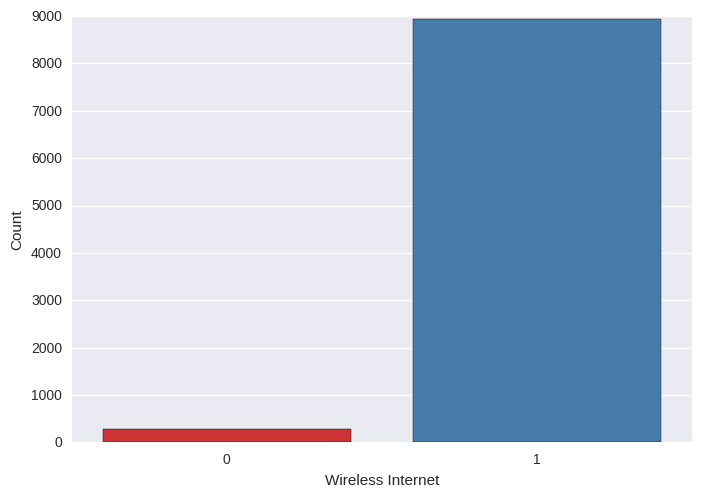

0    7402
1    1830
Name: Buzzer/wireless intercom, dtype: int64


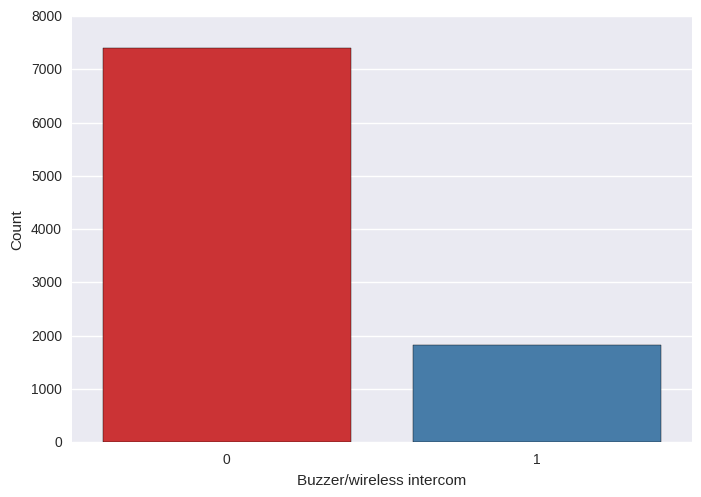

1    8681
0     551
Name: Kitchen, dtype: int64


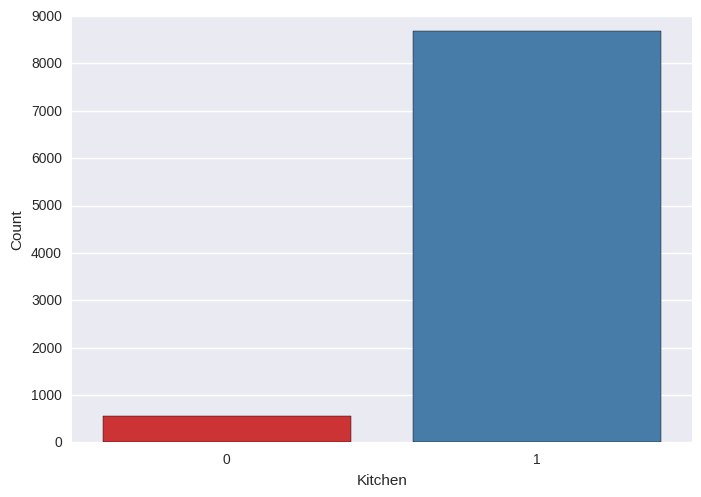

0    7898
1    1334
Name: Doorman, dtype: int64


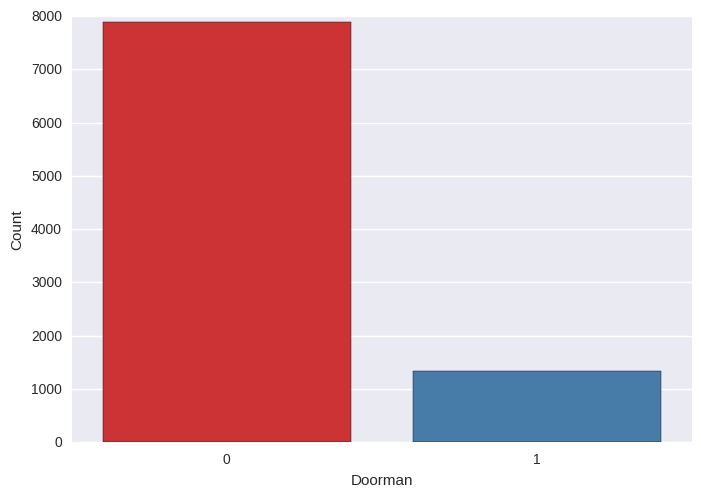

0    7756
1    1476
Name: Wheelchair accessible, dtype: int64


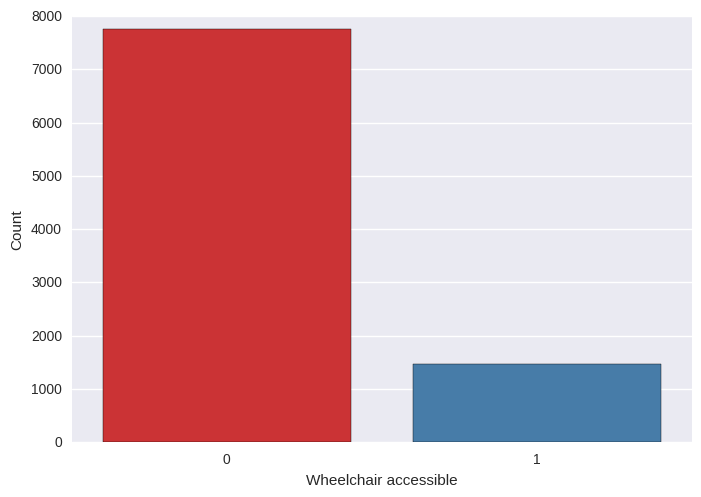

0    6528
1    2704
Name: Cable TV, dtype: int64


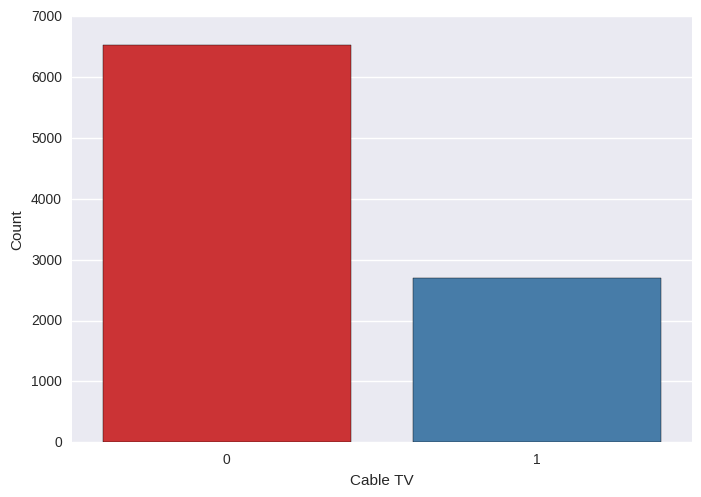

0    7745
1    1487
Name: Hot tub, dtype: int64


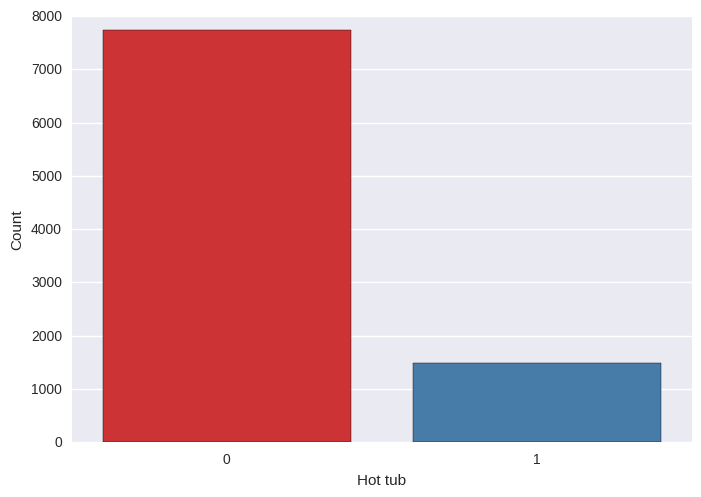

0    6219
1    3013
Name: Gym, dtype: int64


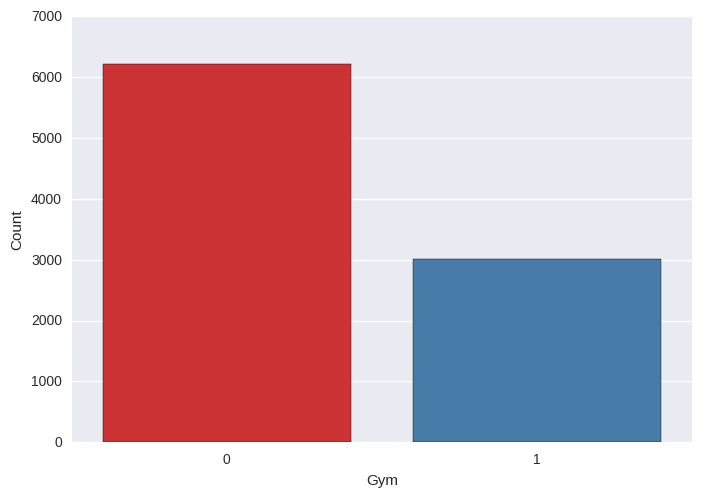

0    7367
1    1865
Name: Pool, dtype: int64


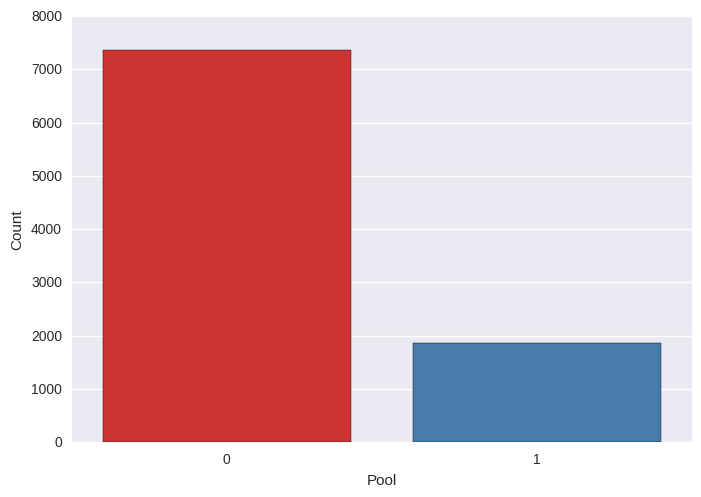

1    6288
0    2944
Name: TV, dtype: int64


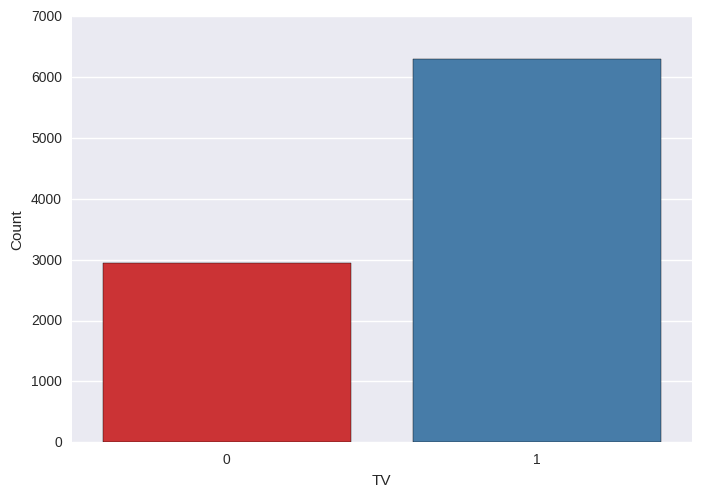

1    7211
0    2021
Name: Dryer, dtype: int64


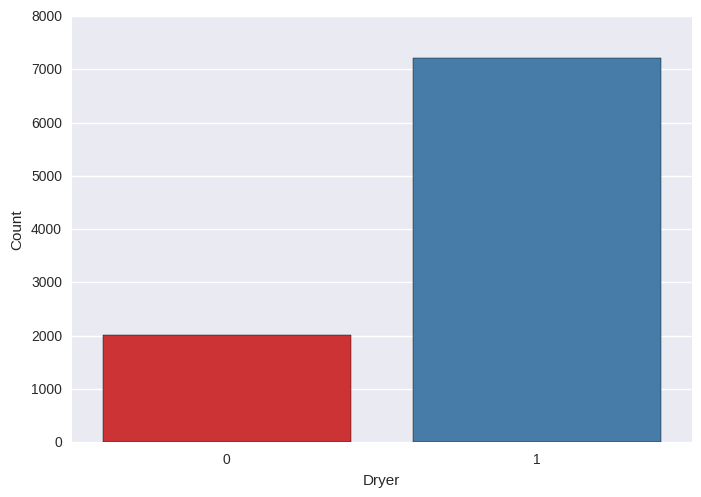

1    7358
0    1874
Name: Washer, dtype: int64


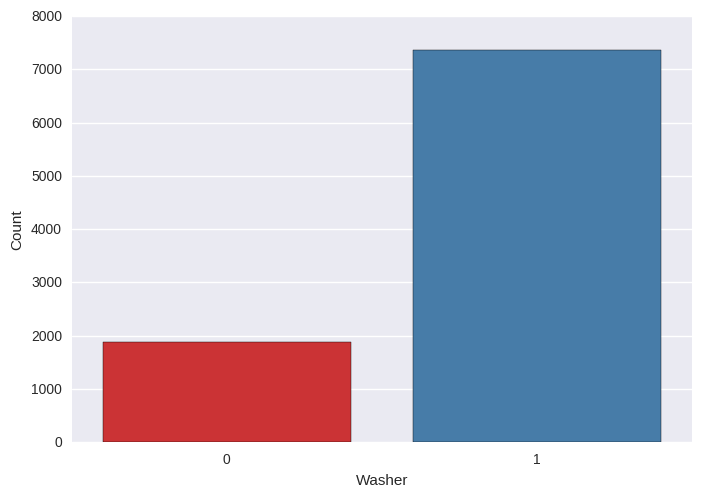

1    8085
0    1147
Name: Essentials, dtype: int64


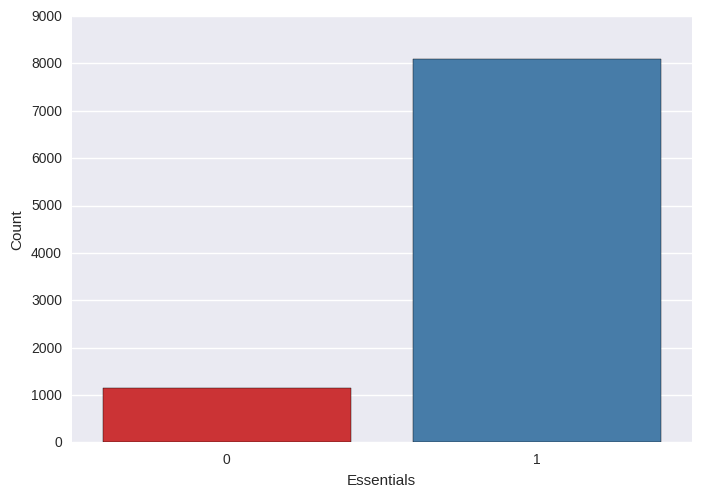

1    6534
0    2698
Name: Shampoo, dtype: int64


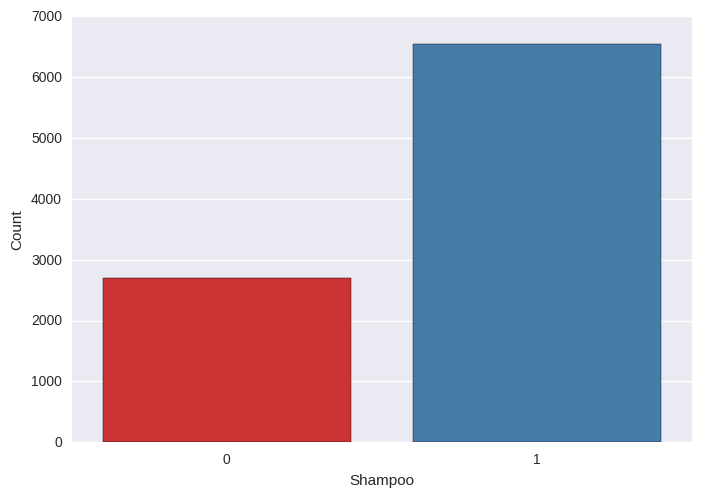

1    8839
0     393
Name: Heating, dtype: int64


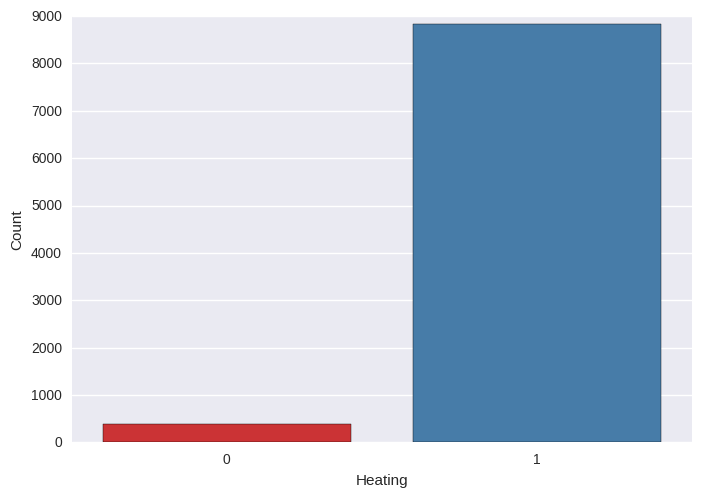

1    7378
0    1854
Name: Air conditioning, dtype: int64


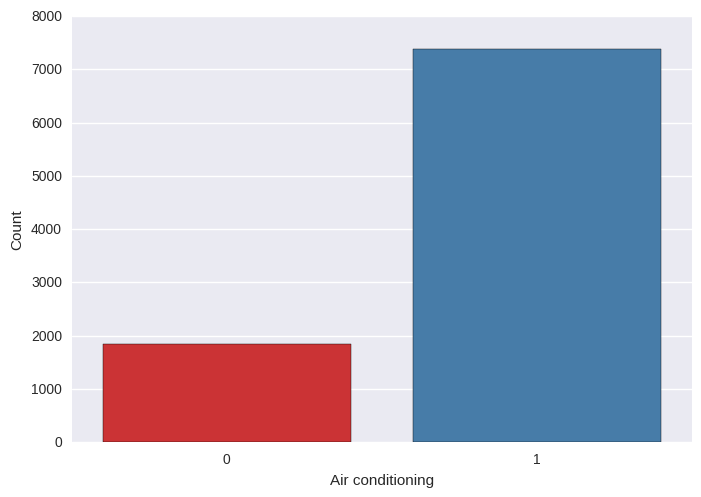

0    7883
1    1349
Name: Pets allowed, dtype: int64


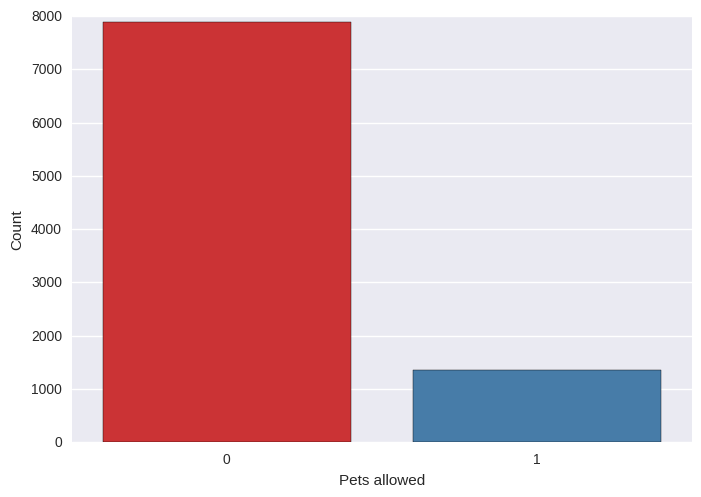

0    8927
1     305
Name: Suitable for events, dtype: int64


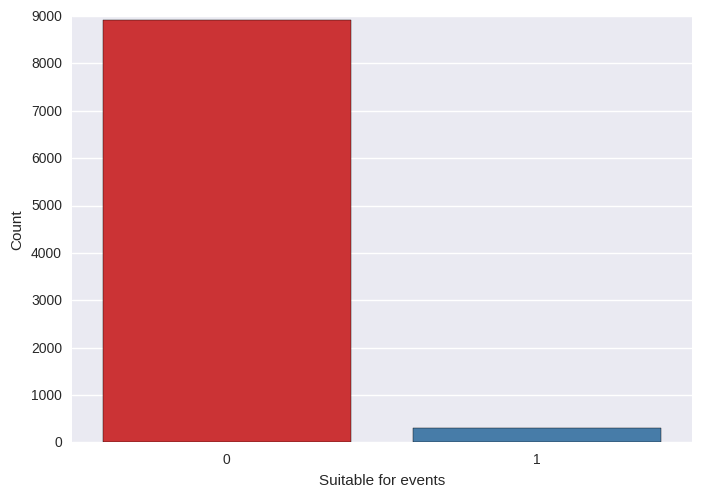

0    8817
1     415
Name: Smoking allowed, dtype: int64


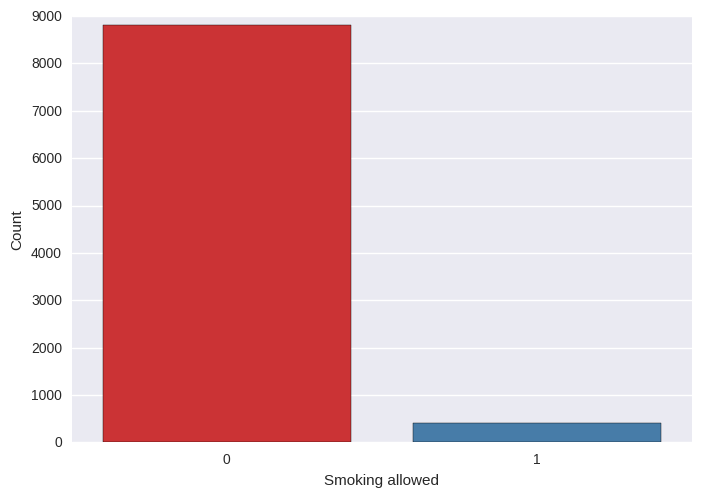

0    8331
1     901
Name: Indoor fireplace, dtype: int64


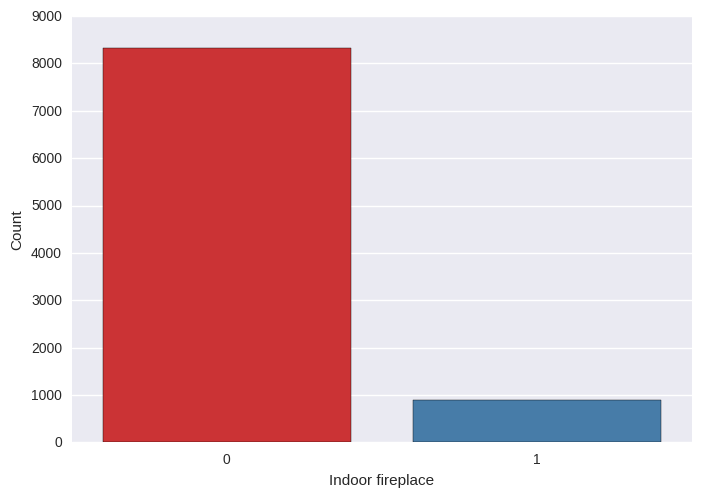

0    8243
1     989
Name: Breakfast, dtype: int64


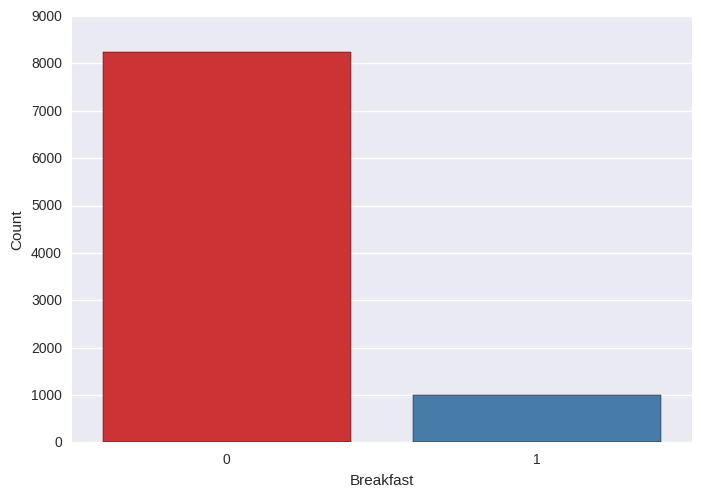

1    5390
0    3842
Name: Laptop friendly workspace, dtype: int64


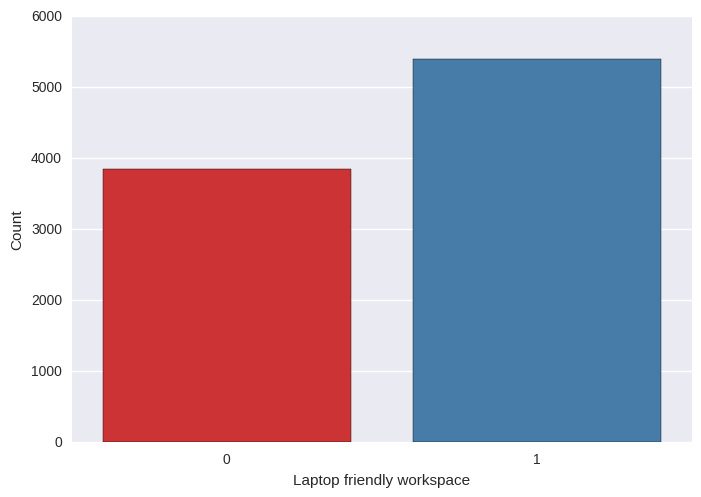

1    5055
0    4177
Name: Iron, dtype: int64


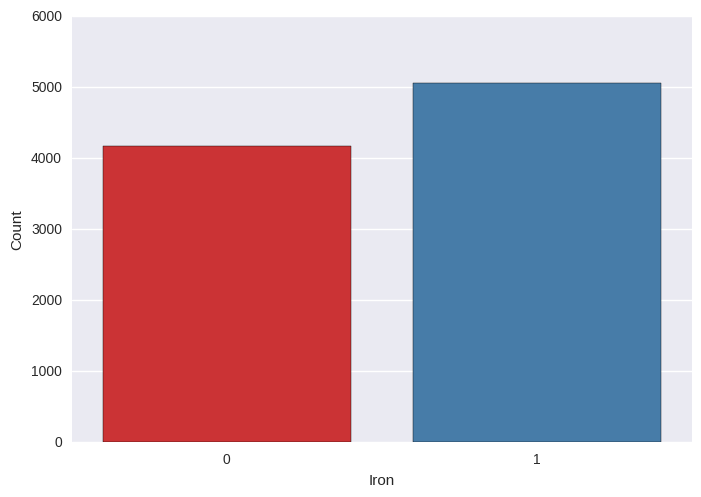

1    6004
0    3228
Name: Hangers, dtype: int64


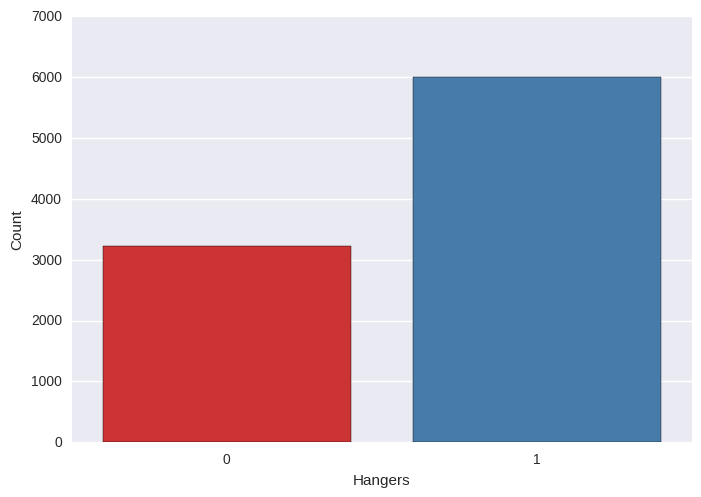

1    5113
0    4119
Name: Hair dryer, dtype: int64


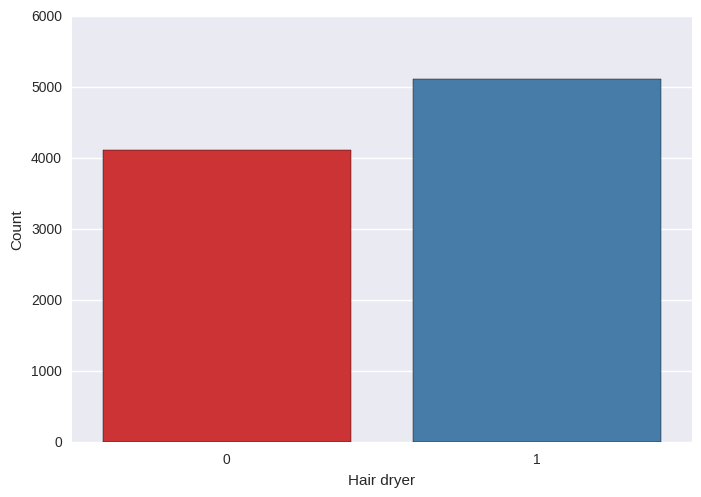

0    9217
1      15
Name: Private living room, dtype: int64


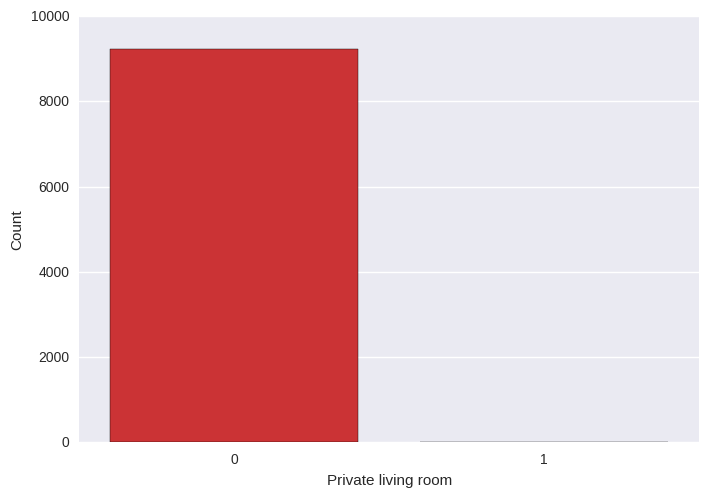

0    9015
1     217
Name: Private entrance, dtype: int64


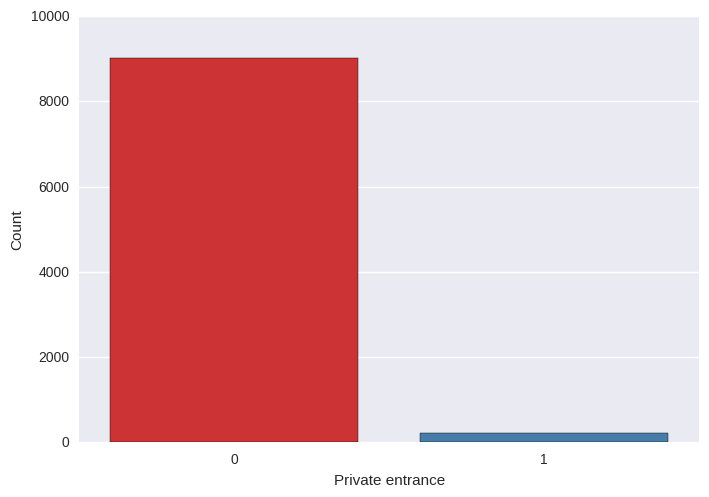

0    5373
1    3859
Name: Parking, dtype: int64


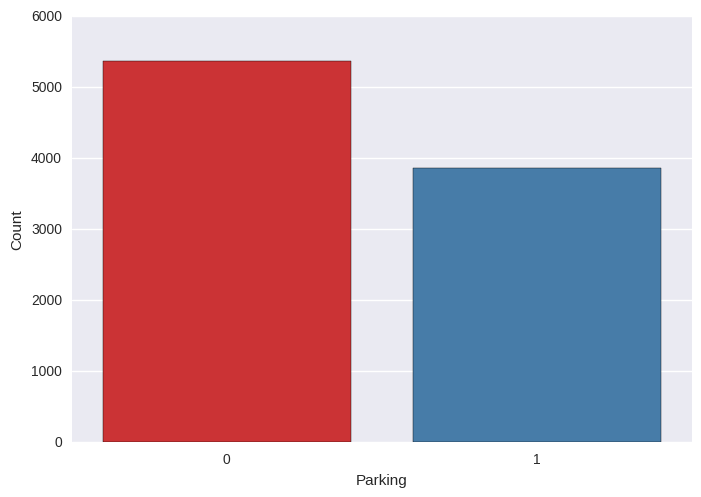

In [33]:
sns.set_style("darkgrid")
for amenity in amenities:
    print df[amenity].value_counts()
    sns.barplot(pd.Series(df[amenity].value_counts()).index, pd.Series(df[amenity].value_counts()).values, palette='Set1')
    plt.ylabel('Count')
    plt.xlabel(amenity)
    plt.show()

<code>
We tried scatter plot with price on the y-axis and amenity on the y-axis to check if that variable is correlated with price. But we observe only a small slope to the fit values (Like Below).
Hence, we just report the correlation values between price and each amenity. 
Most of the amenities have mildly positive correlaton with price.
</code>

Correlation between Price and Amenity-Indoor Fireplace: 0.0582255205247


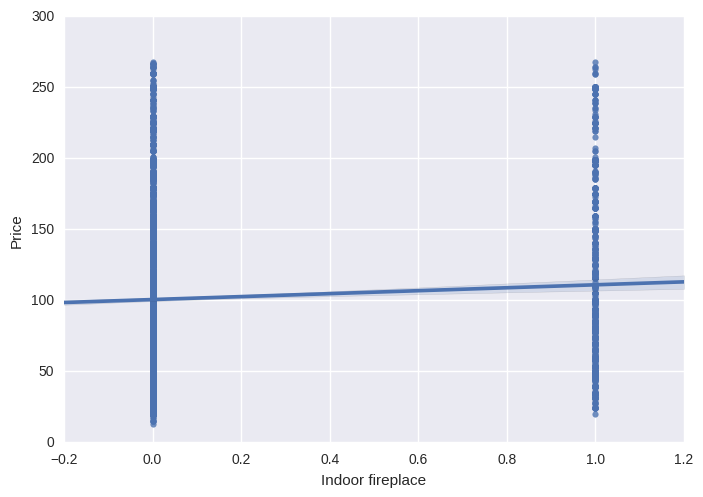

In [34]:
sns.regplot(x='Indoor fireplace', y='price', data=df)
plt.ylabel('Price')
print "Correlation between Price and Amenity-Indoor Fireplace:", np.corrcoef(df['Indoor fireplace'], df['price'])[0, 1]

In [35]:
for amenity in amenities:
    # Pearson Correlation Coefficient
    print "Correlation between Price and ", amenity, " = ", np.corrcoef(df[amenity], df['price'])[0, 1]

Correlation between Price and  Elevator in building  =  0.267248666981
Correlation between Price and  Internet  =  0.10589388943
Correlation between Price and  Family/kid friendly  =  0.282988335375
Correlation between Price and  Wireless Internet  =  0.0279644547628
Correlation between Price and  Buzzer/wireless intercom  =  0.0846565926537
Correlation between Price and  Kitchen  =  0.127631424068
Correlation between Price and  Doorman  =  0.183593431397
Correlation between Price and  Wheelchair accessible  =  0.156676589726
Correlation between Price and  Cable TV  =  0.222721690081
Correlation between Price and  Hot tub  =  0.153457029762
Correlation between Price and  Gym  =  0.278755743575
Correlation between Price and  Pool  =  0.171109567347
Correlation between Price and  TV  =  0.317753979295
Correlation between Price and  Dryer  =  0.196322168805
Correlation between Price and  Washer  =  0.178359714312
Correlation between Price and  Essentials  =  0.0591531104863
Correlation be

### Neighbourhood Facility

<code>This is basically the distance (in metres) of different neighbourhood amenities (like bus stop, shopping mall, etc.) from the listed house/appartment. 
While scraping this data, a value of -1 was given if a particular facility was not present within the threshold radius. Such rows need to be removed for plotting.

In [36]:
neighbourhood_facilities = [u'restaurant', u'atm', u'cinema', u'hospital', u'nightclub', u'park', u'mall',
                            u'gallery', u'museum', u'supermarket', u'bus_stop']
colours = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

<code>In terms of correlation, we see that the neighbourhood facility distance variable is usually negatively correlated with price. This makes sense because when the facilities are located closer (less distance) to the house/appartment, the hosts would usually charge a higher price.

The summary statistics - mean, median, min, max, std values of the neighbourhood facility distance variables are also tabulated  

Number of records with no restaurant present within the threshold radius:  25
count    9207.000000
mean      285.397198
std       278.682368
min         0.000000
25%        90.000000
50%       188.000000
75%       393.000000
max      1989.000000
Name: restaurant, dtype: float64


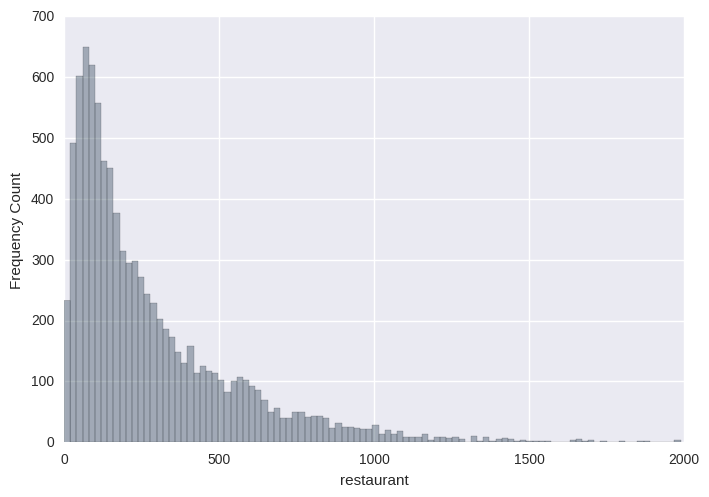

Correlation between Price and  restaurant distance =  -0.223324042211


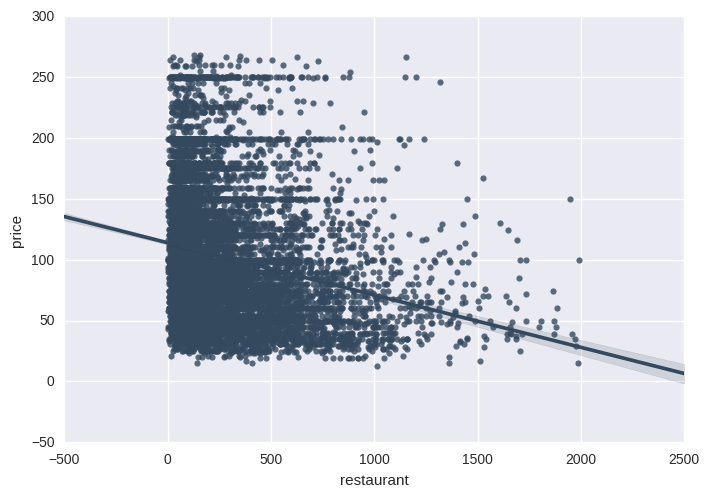

Number of records with no atm present within the threshold radius:  0
count    9232.000000
mean      988.184467
std       873.901389
min         6.000000
25%       295.000000
50%       694.500000
75%      1439.250000
max      4802.000000
Name: atm, dtype: float64


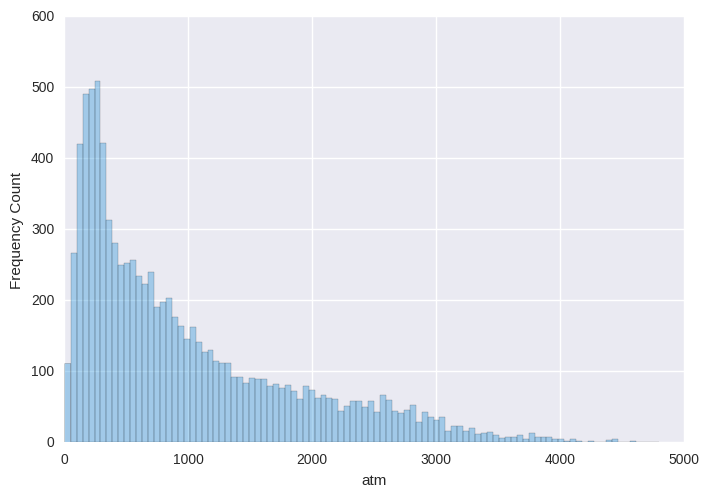

Correlation between Price and  atm distance =  -0.230885317857


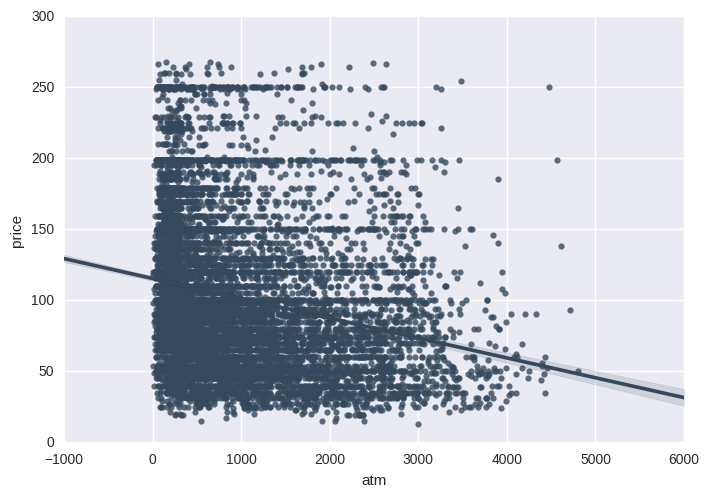

Number of records with no cinema present within the threshold radius:  0
count     9232.000000
mean      1692.292353
std       1361.437231
min         14.000000
25%        783.000000
50%       1386.500000
75%       2256.000000
max      12582.000000
Name: cinema, dtype: float64


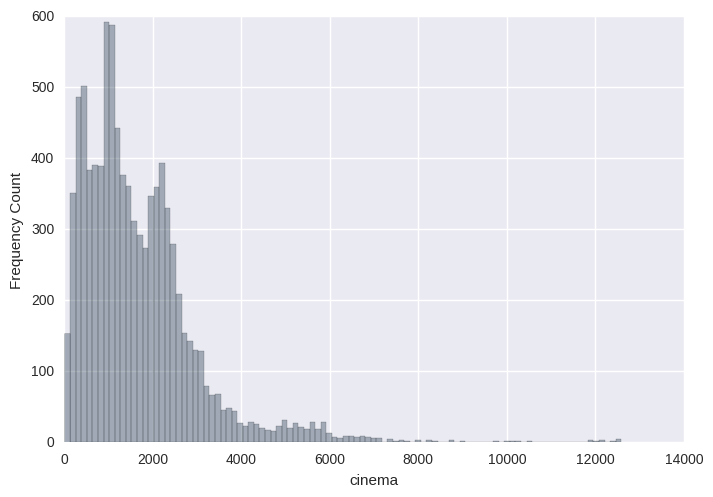

Correlation between Price and  cinema distance =  -0.233159477273


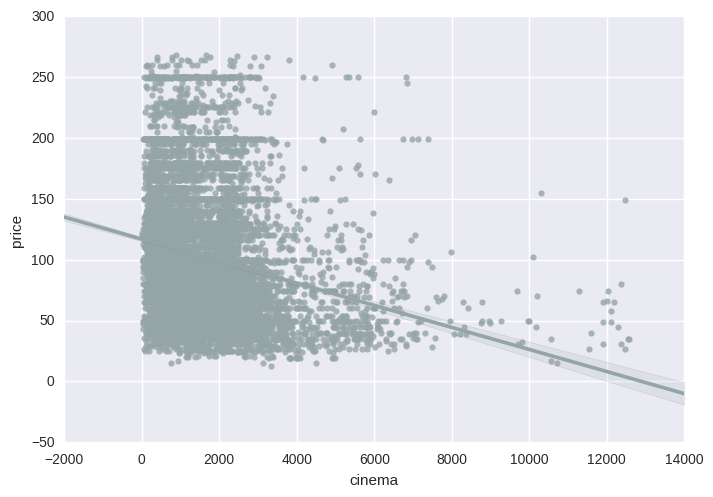

Number of records with no hospital present within the threshold radius:  1
count     9231.000000
mean      2227.323259
std       1724.066106
min         30.000000
25%       1074.500000
50%       1759.000000
75%       2666.000000
max      11126.000000
Name: hospital, dtype: float64


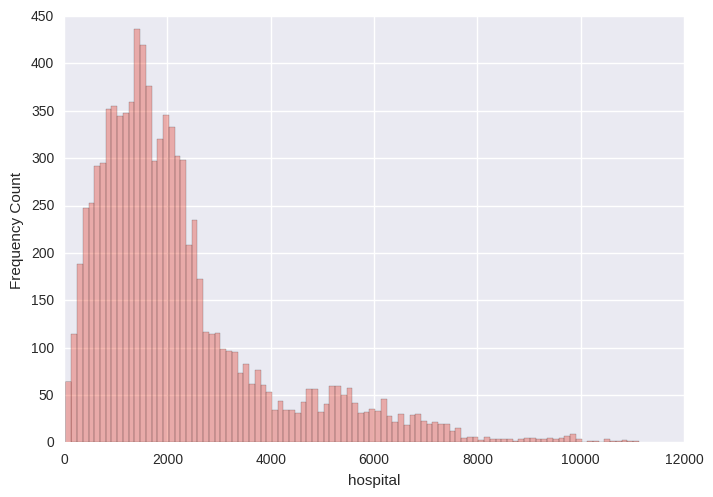

Correlation between Price and  hospital distance =  -0.122982595374


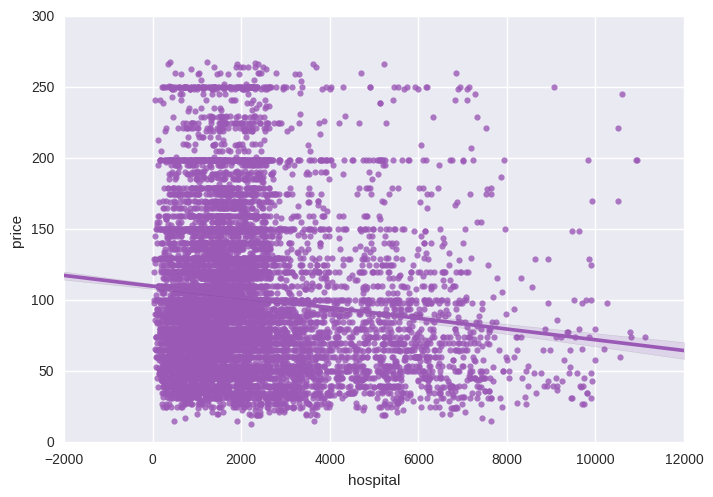

Number of records with no nightclub present within the threshold radius:  562
count    8670.000000
mean     2631.618108
std      2420.599720
min         3.000000
25%       797.250000
50%      1707.000000
75%      4090.750000
max      9993.000000
Name: nightclub, dtype: float64


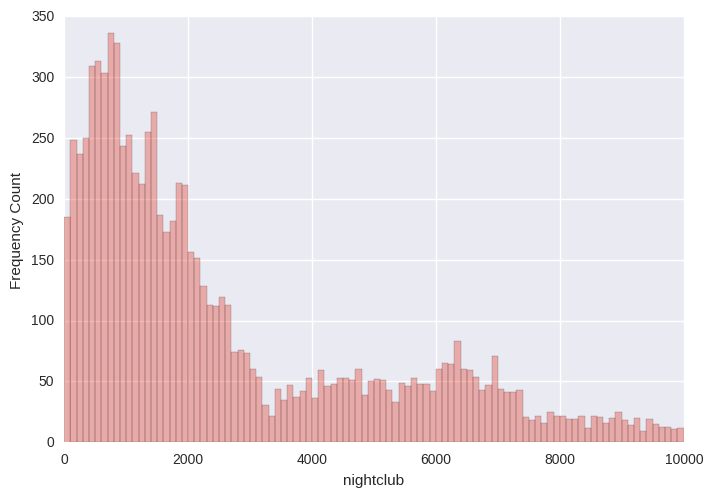

Correlation between Price and  nightclub distance =  -0.1653483445


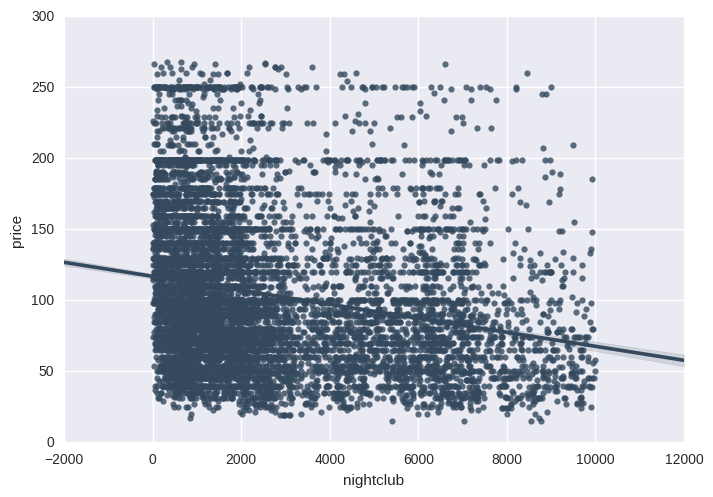

Number of records with no park present within the threshold radius:  0
count    9232.000000
mean     1757.888432
std       806.917227
min        32.000000
25%      1158.750000
50%      1746.000000
75%      2316.000000
max      4890.000000
Name: park, dtype: float64


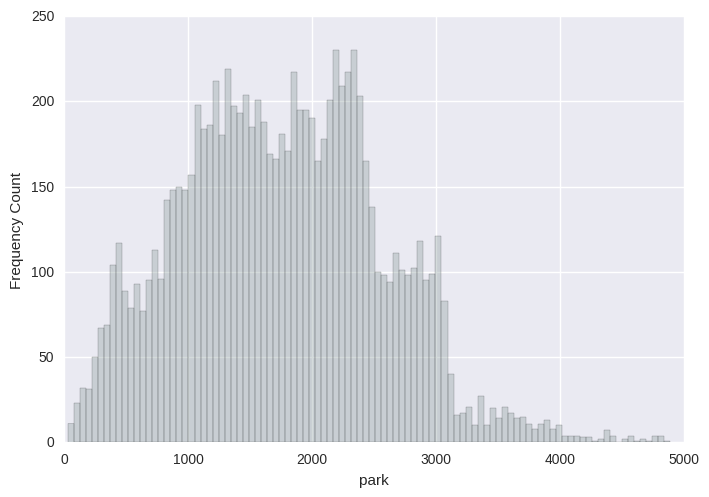

Correlation between Price and  park distance =  0.088600584347


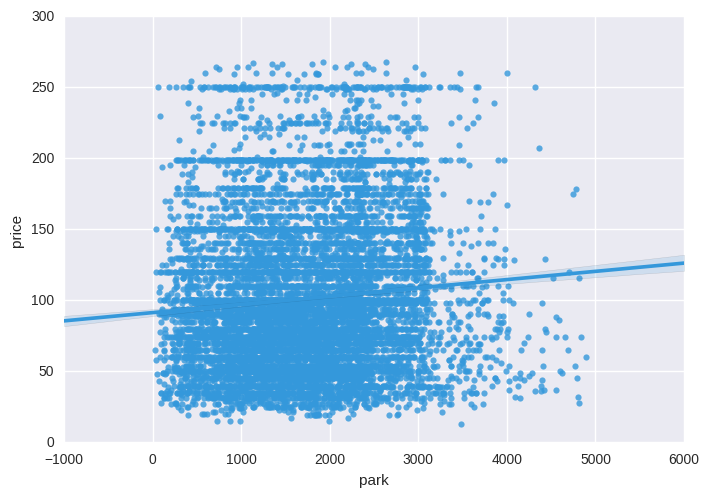

Number of records with no mall present within the threshold radius:  415
count     8817.000000
mean      2984.054667
std       2335.255837
min         12.000000
25%       1122.000000
50%       2266.000000
75%       4282.000000
max      10007.000000
Name: mall, dtype: float64


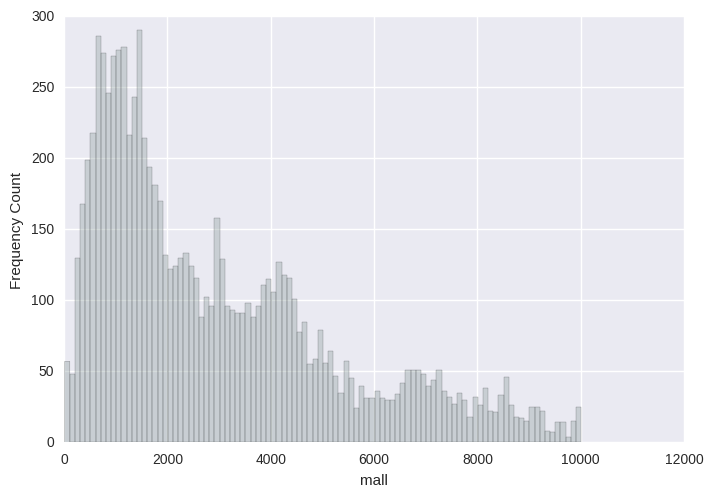

Correlation between Price and  mall distance =  -0.194790816883


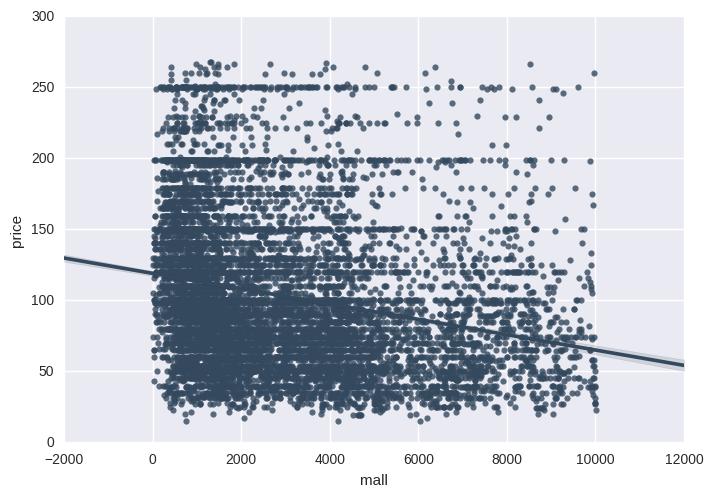

Number of records with no gallery present within the threshold radius:  1314
count     7918.000000
mean      3217.533215
std       2352.479219
min         16.000000
25%       1426.250000
50%       2549.500000
75%       4370.000000
max      10007.000000
Name: gallery, dtype: float64


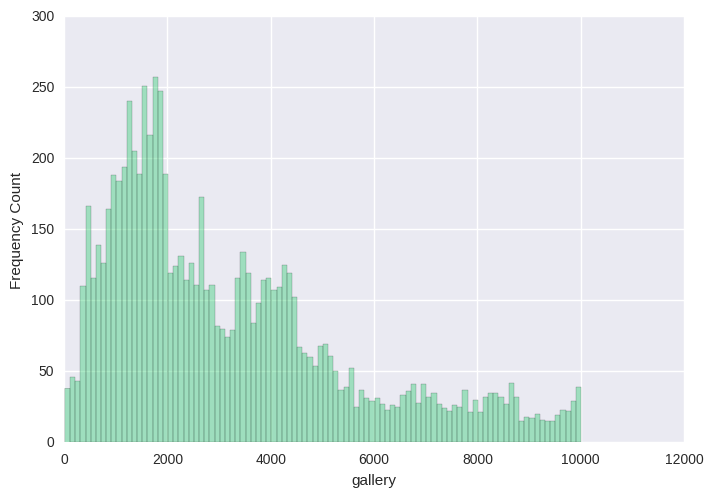

Correlation between Price and  gallery distance =  -0.0843030437348


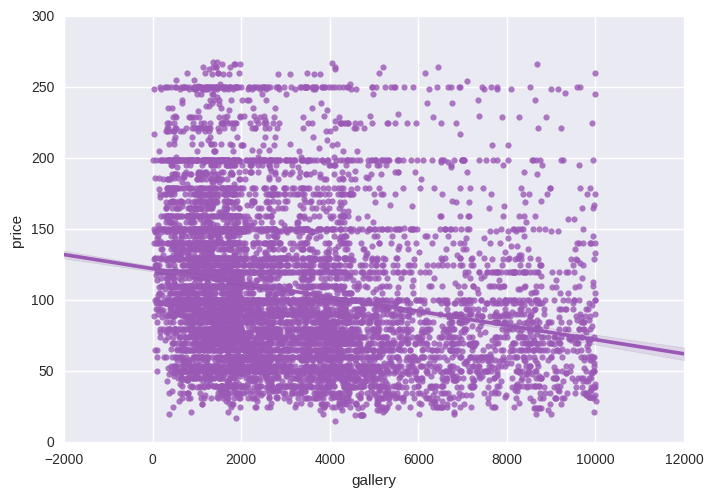

Number of records with no museum present within the threshold radius:  81
count    9151.000000
mean     2492.881434
std      2428.521200
min         4.000000
25%       610.000000
50%      1326.000000
75%      3894.000000
max      9995.000000
Name: museum, dtype: float64


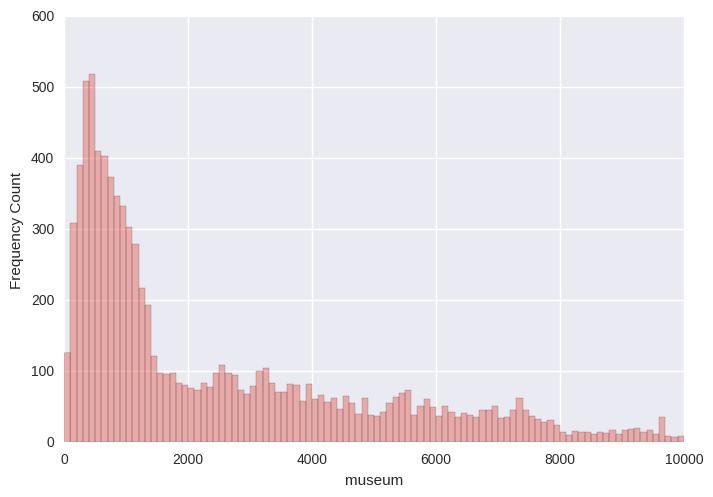

Correlation between Price and  museum distance =  -0.23589074457


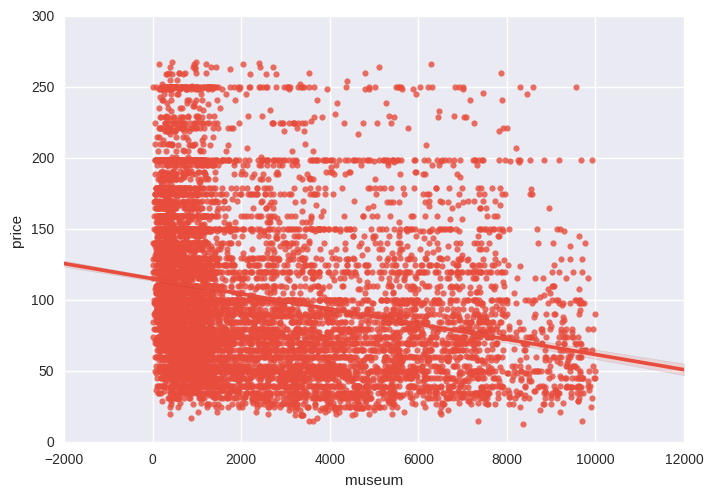

Number of records with no supermarket present within the threshold radius:  0
count    9232.000000
mean      441.388865
std       363.706890
min         4.000000
25%       187.000000
50%       339.000000
75%       576.000000
max      2955.000000
Name: supermarket, dtype: float64


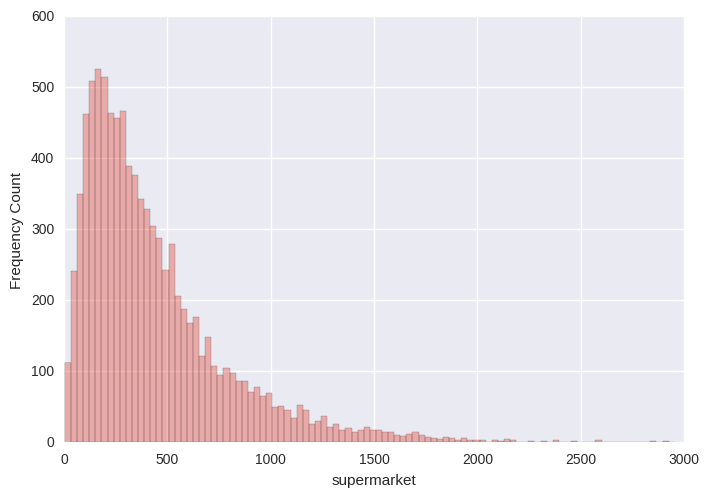

Correlation between Price and  supermarket distance =  -0.202417986245


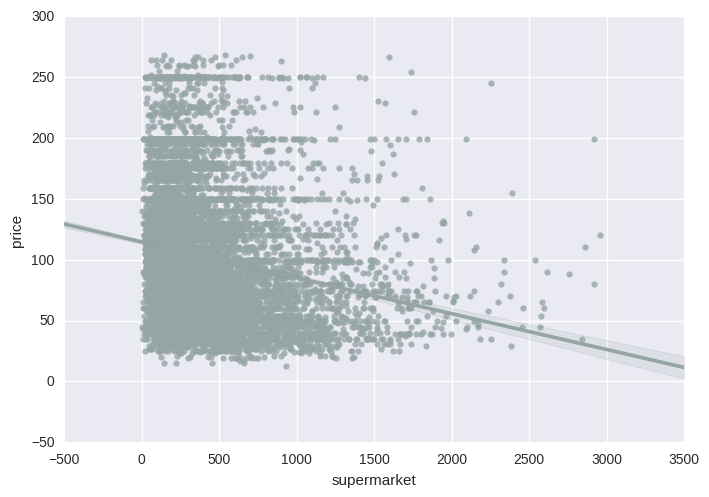

Number of records with no bus_stop present within the threshold radius:  9
count    9223.000000
mean      186.681340
std       134.549468
min         2.000000
25%        89.000000
50%       151.000000
75%       252.000000
max       999.000000
Name: bus_stop, dtype: float64


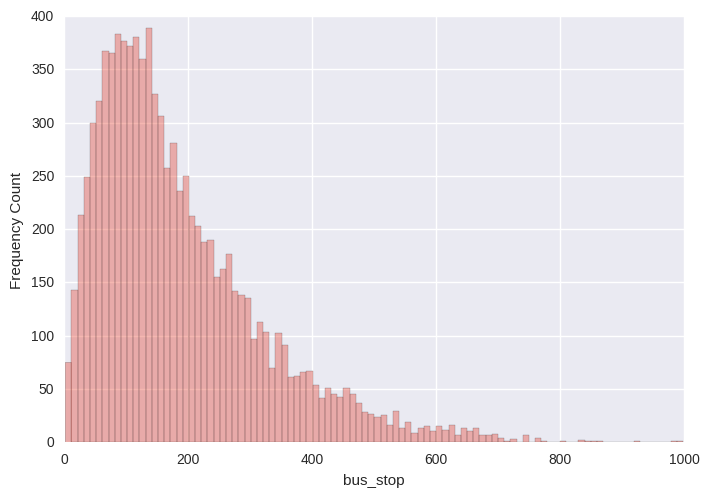

Correlation between Price and  bus_stop distance =  -0.0548357758516


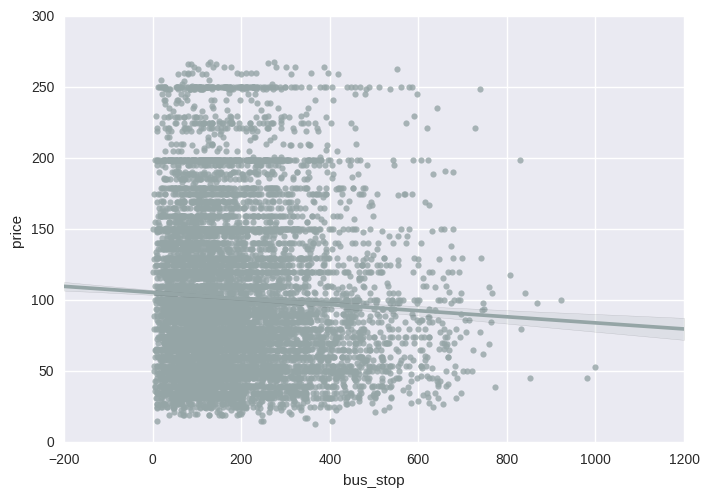

In [37]:
for (i, facility) in enumerate(neighbourhood_facilities):
    df_subset = df.drop(df[df[facility] == -1].index, axis=0)
    print "Number of records with no", facility, "present within the threshold radius: ", len(df[facility]) -len(df_subset[facility])
    print df_subset[facility].describe()
    sns.distplot(df_subset[facility], kde=False, axlabel=facility, color=np.random.choice(colours, 1)[0], bins=100)
    plt.ylabel('Frequency Count')
    plt.show()
    print "Correlation between Price and ", facility, "distance = ", np.corrcoef(df[facility], df['price'])[0, 1]
    sns.regplot(x=facility, y='price', data=df_subset, color=np.random.choice(colours, 1)[0])
    plt.show()

### Text Data
<code>Build Word Cloud for reviews and listing descriptions

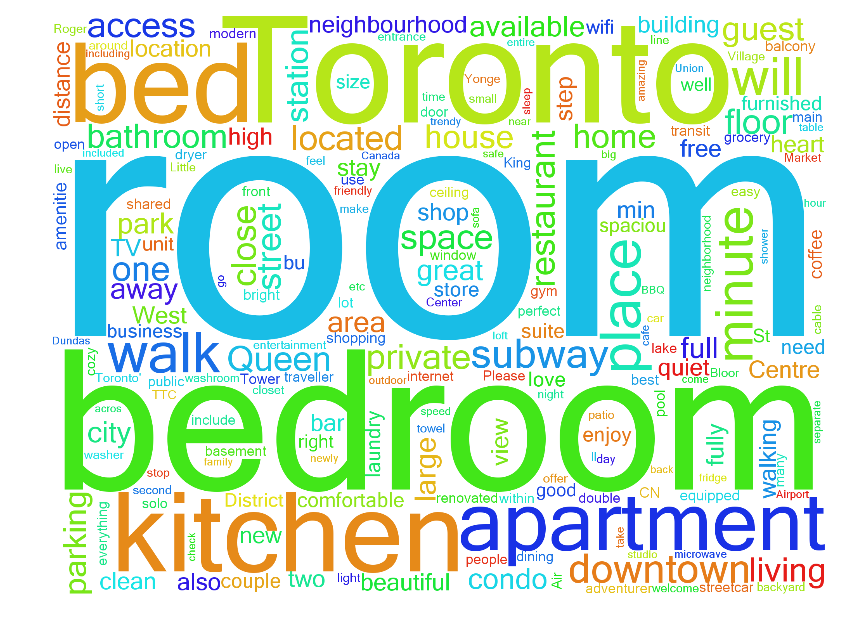

In [55]:
from wordcloud import WordCloud, STOPWORDS

descriptions_string = ' '.join(df.ix[df[-df.description.isnull()].index, 'description'])

wordcloud = WordCloud(font_path='Microsoft_Sans_Serif.ttf',
                          stopwords=STOPWORDS,background_color='white', height = 1500, width = 2000).generate(descriptions_string)

plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


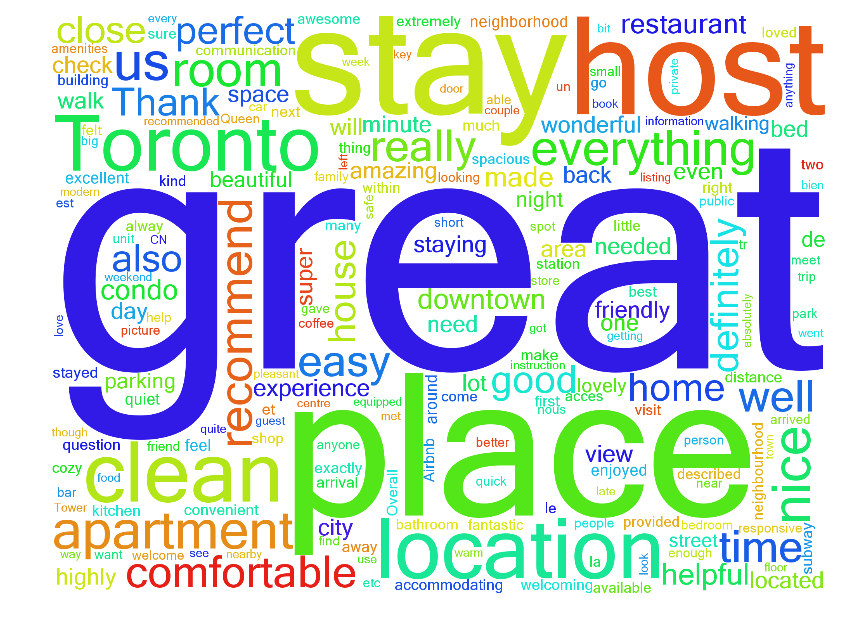

In [62]:
df_reviews = pd.read_csv('/home/hareesh/Research/big_data/project/airbnb/inside_airbnb/toronto/reviews.csv')
reviews_string = ' '.join(df_reviews.ix[df[-df_reviews.comments.isnull()].index, 'comments'])

wordcloud = WordCloud(font_path='Microsoft_Sans_Serif.ttf',
                          stopwords=STOPWORDS,background_color='white', height = 1500, width = 2000).generate(reviews_string)

plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()